# Анализ динамики роста ВВП Ганы (1960–2021)

## Визуализация и исследование экономического роста страны на основе временного ряда

Государственная компания проводит анализ экономической ситуации по заказу государства.

Требуется провести анализ временного ряда ВВП африканской страны Гана. Для исследования предоставлены [показатели ВВП](https://lms.skillfactory.ru/assets/courseware/v1/cf3fb9ca311981f5cc6b6f0a40621388/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ghana_gdp.zip) за 62 года. Необходимо изучить свойства временного ряда, построить модели и сделать выводы по результатам анализа.

## **1. Подготовка данных**

In [53]:
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots  
import plotly.graph_objects as go  
import plotly.express as  px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from prophet import Prophet
import plotly.io as pio

pio.renderers.default= 'png'



In [54]:
ghana_gdp_zip = pd.read_csv('C:/Users/admin/Desktop/$/DS_education/math ml 13/ghana_gdp.zip', compression='zip', parse_dates=['year'], index_col=['year'], )
ghana_gdp = ghana_gdp_zip.copy()
ghana_gdp.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Обработка данных

In [55]:
# Заменим значения ВВП равные нулю на NaN для корректного анализа
ghana_gdp.replace(0, np.nan, inplace=True)

# Посмотрим пропуски
print("Количество пропусков после замены нулей:", ghana_gdp.isna().sum())

# Если нужно, можно заполнить пропуски, например, методом интерполяции:
ghana_gdp.interpolate(method='linear', inplace=True)

# Проверим итог
print(ghana_gdp.head())

Количество пропусков после замены нулей: GDP (current US$)    1
dtype: int64
            GDP (current US$)
year                         
1960-01-01       1.217087e+09
1961-01-01       1.299720e+09
1962-01-01       1.382353e+09
1963-01-01       1.540616e+09
1964-01-01       1.731092e+09


Визуализация

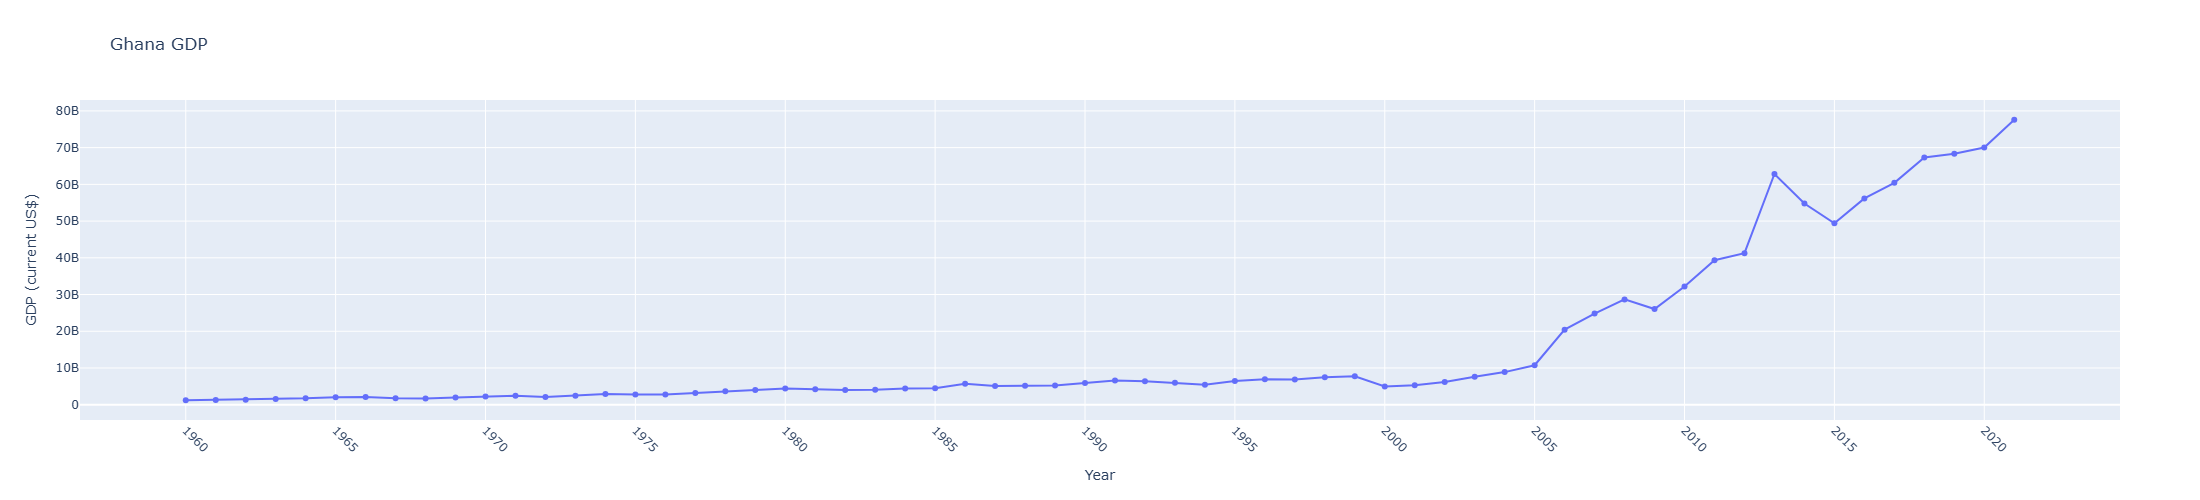

In [56]:
# Визуализация ВВП Ганы по годам
x_years = ghana_gdp.index.year.astype(str)
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_years, y=ghana_gdp['GDP (current US$)'], mode='lines+markers'))

# Подписи только для каждого 5-го года
tickvals = x_years[::5]

fig.update_layout(
    title='Ghana GDP',
    xaxis_title='Year',
    yaxis_title='GDP (current US$)',
    width=2200,
    height=500,
    xaxis_tickmode='array',
    xaxis_tickvals=tickvals,
    xaxis_ticktext=tickvals,
    xaxis_tickangle=45
)
fig.show()

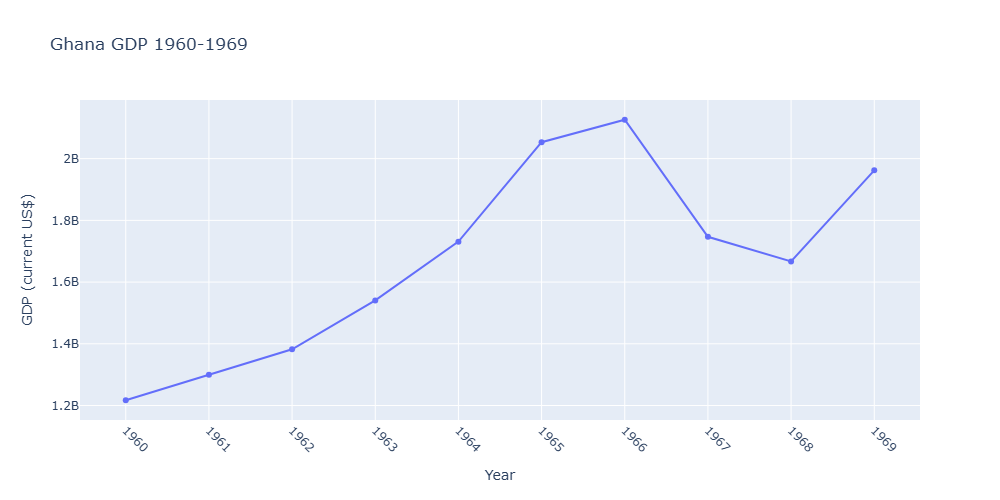

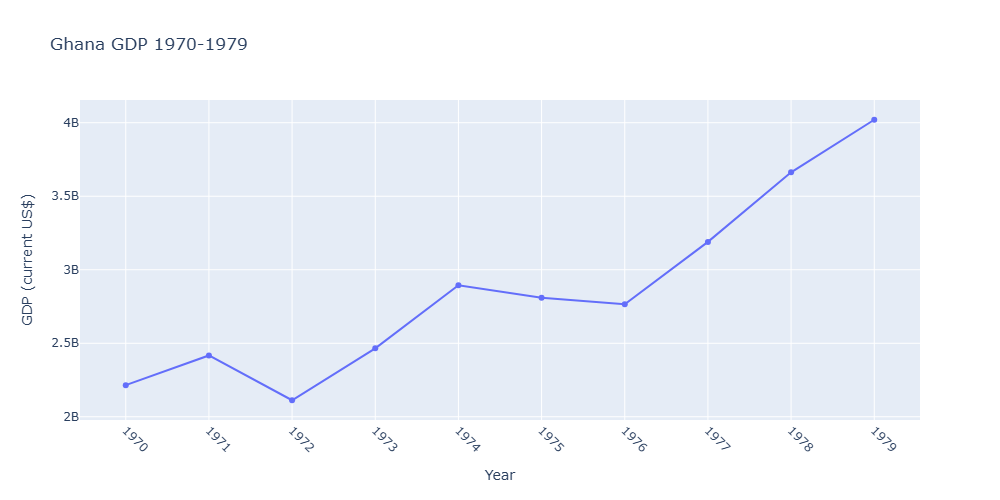

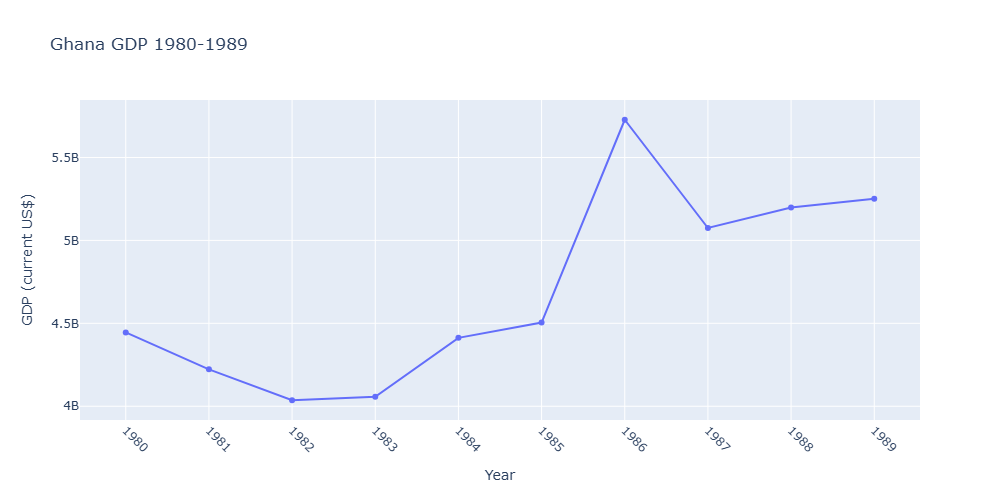

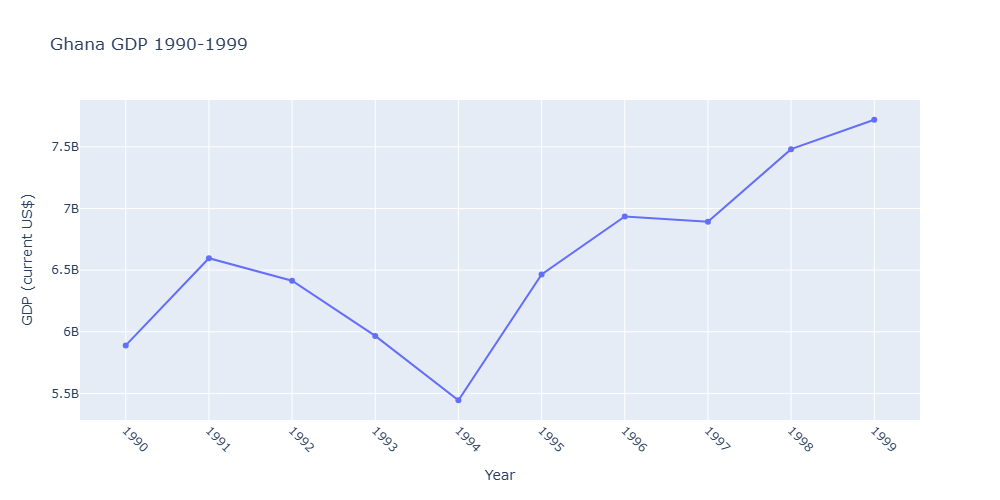

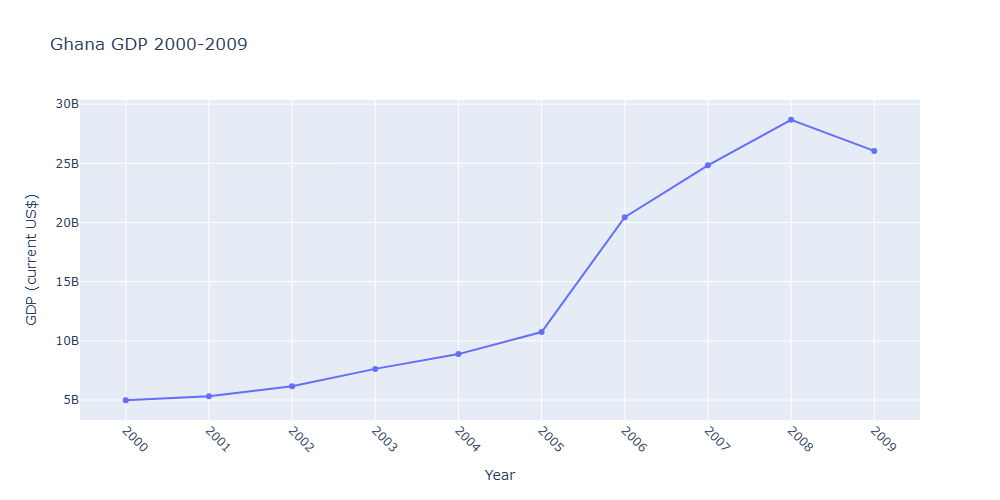

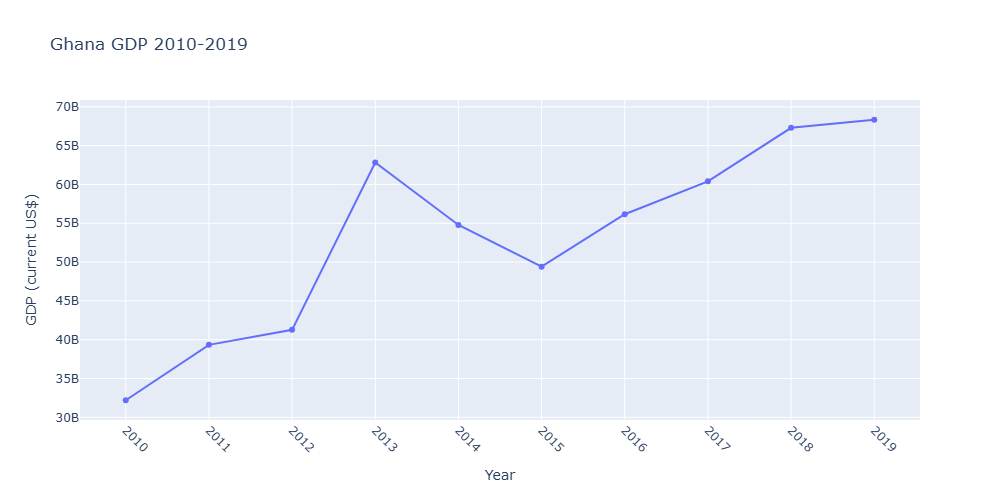

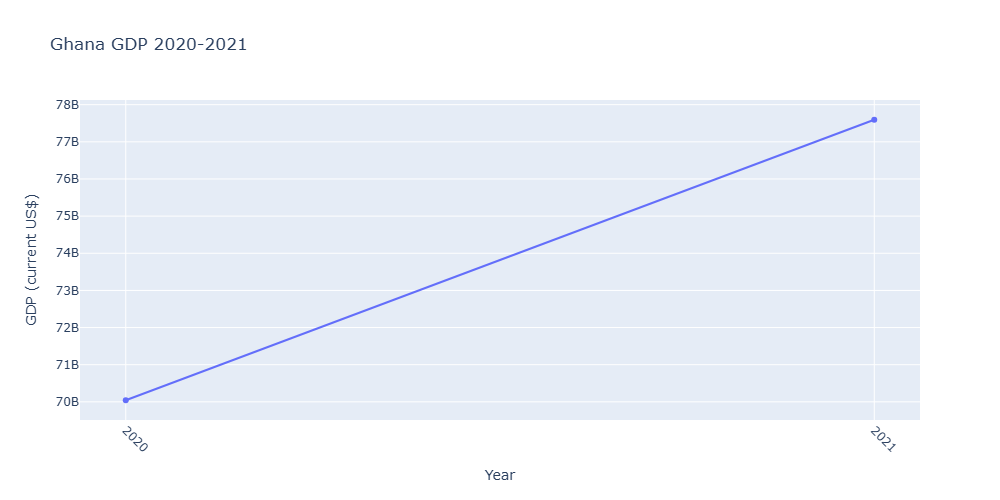

In [57]:
# Визуализация ВВП Ганы по десятилетиям
decades = [(1960 + i*10, min(1960 + (i+1)*10 - 1, ghana_gdp.index.year.max())) 
           for i in range((ghana_gdp.index.year.max() - 1960)//10 + 1)]

for start, end in decades:
    mask = (ghana_gdp.index.year >= start) & (ghana_gdp.index.year <= end)
    x_years_decade = ghana_gdp.index[mask].year.astype(str)  # строки для подписей
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_years_decade, y=ghana_gdp.loc[mask, 'GDP (current US$)'],
                             mode='lines+markers', name=f'{start}-{end}'))
    fig.update_layout(
        title=f'Ghana GDP {start}-{end}',
        xaxis_title='Year',
        yaxis_title='GDP (current US$)',
        width=1000,
        xaxis_tickmode='array',
        xaxis_tickvals=x_years_decade,
        xaxis_ticktext=x_years_decade,
        xaxis_tickangle=45
    )
    fig.show()

In [58]:
# Создадим датафрейм с разницей и отношением ВВП по десятилетиям
ghana_10 = pd.DataFrame()
years = ghana_gdp.index.year.unique()

for start in range(1960, 2030, 10):
    end = start + 10
    if end > years.max():
        break
    try:
        gdp_start = ghana_gdp.loc[ghana_gdp.index.year == start, 'GDP (current US$)'].values[0]
        gdp_end = ghana_gdp.loc[ghana_gdp.index.year == end, 'GDP (current US$)'].values[0]
        dif_ghana = gdp_end - gdp_start
        dif_ghana_fois = gdp_end / gdp_start if gdp_start != 0 else np.nan
        dif_df = pd.DataFrame({'dif': [dif_ghana], 'dif_fois': [dif_ghana_fois]}, index=[pd.Timestamp(f'{end}-01-01')])
        ghana_10 = pd.concat([ghana_10, dif_df])
    except IndexError:
        continue

print(ghana_10)
print(ghana_10.loc[:pd.Timestamp('2020-01-01')].describe())

                     dif  dif_fois
1970-01-01  9.979426e+08  1.819944
1980-01-01  2.230199e+09  2.006848
1990-01-01  1.443947e+09  1.324831
2000-01-01 -9.061504e+08  0.846133
2010-01-01  2.721425e+10  6.461392
2020-01-01  3.784593e+10  2.175439
                dif  dif_fois
count  6.000000e+00  6.000000
mean   1.147102e+10  2.439098
std    1.668712e+10  2.029664
min   -9.061504e+08  0.846133
25%    1.109444e+09  1.448609
50%    1.837073e+09  1.913396
75%    2.096824e+10  2.133291
max    3.784593e+10  6.461392


Данные охватывают период 1960–2021 гг. В среднем ВВП увеличивался в 2,4 раза за десятилетие (11,47 млрд US$). Максимальный рост зафиксирован в 2000–2010 годах (в 6,46 раза), а в 1990–2020 наблюдалось снижение (в 0,84 раза).

Для дальнейшего анализа датасет будет разделён на обучающую и тестовую выборки: тестовой станет период последних трёх лет.

In [59]:
# Разделение на обучающую и тестовую выборки (последние 3 года — тест)
split_date = ghana_gdp.index[-4] if len(ghana_gdp) > 3 else ghana_gdp.index[0]
train_ghana = ghana_gdp.loc[:split_date].copy()
test_ghana = ghana_gdp.loc[split_date + pd.Timedelta(days=1):].copy()

print(train_ghana.shape, test_ghana.shape)

(59, 1) (3, 1)


## **2. SMA (простое скользящее среднее)**

Для начала выполним декомпозицию временного ряда на компоненты: тренд, сезонность (цикличность) и шум.

In [60]:
# Декомпозиция временного ряда
# Заполним NaN в тренде, если есть (после декомпозиции могут появиться)
result = seasonal_decompose(train_ghana['GDP (current US$)'], model='additive', period=1)
result_trend = result.trend.fillna(method='ffill').fillna(method='bfill')
result_seasonal = result.seasonal.fillna(0)
result_resid = result.resid.fillna(0)

C:\Users\admin\AppData\Local\Temp\ipykernel_14020\3512431395.py:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



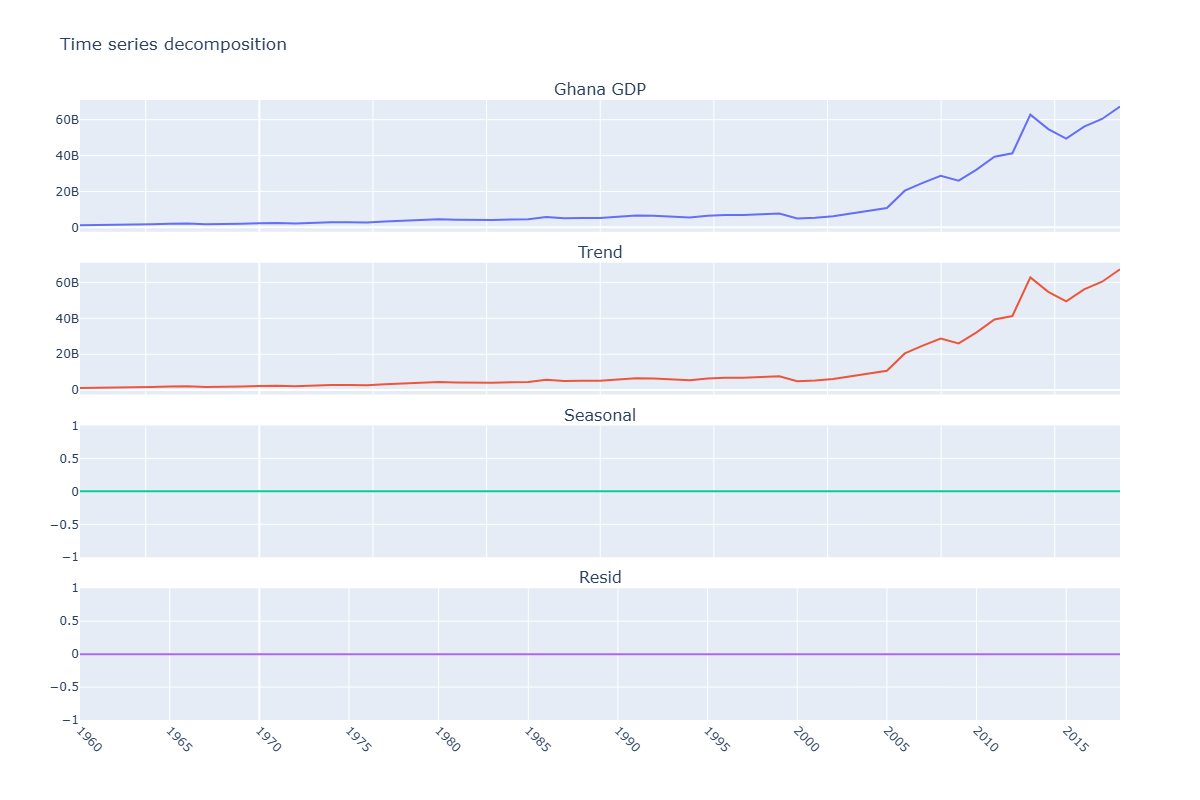

In [61]:
fig = make_subplots(
    rows=4, cols=1,
    row_heights=[0.25, 0.25, 0.25, 0.25],
    subplot_titles=['Ghana GDP', 'Trend', 'Seasonal', 'Resid'],
    shared_xaxes=True,
    vertical_spacing=0.05
)
fig.add_trace(go.Scatter(x=train_ghana.index, y=train_ghana['GDP (current US$)'], mode='lines', showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=train_ghana.index, y=result_trend, mode='lines', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=train_ghana.index, y=result_seasonal, mode='lines', showlegend=False), row=3, col=1)
fig.add_trace(go.Scatter(x=train_ghana.index, y=result_resid, mode='lines', showlegend=False), row=4, col=1)
tickvals = train_ghana.index[::5]
ticktext = [str(year.year) for year in tickvals]

fig.update_xaxes(
    tickmode='array',
    tickvals=tickvals,
    ticktext=ticktext,
    tickangle=45,
    row=4, col=1  # метки годов показываем только на нижнем графике
)
for r in range(1, 4):
    fig.update_xaxes(showticklabels=False, row=r, col=1)
fig.update_layout(
    height=800,
    width=1200,
    title_text='Time series decomposition'
)

fig.show()


- С 2004 года наблюдается отчетливо выраженный восходящий тренд в графиках GDP и Trend, что указывает на уверенный экономический рост Ганы. В период с 1960 по 2004 год изменения ВВП очень плавные и практически незаметны (график выглядит «ползучим»).
- Сезонность (цикличность) отсутствует — график Seasonal практически равен нулю на всём протяжении.
- Компонента Resid отражает белый шум, колеблющийся около нулевого значения, без выраженной структуры.
  
Для дополнительного анализа применим метод простого скользящего среднего (SMA) с окнами длиной 1, 5 и 10 лет соответственно. Этот метод служит для сглаживания временного ряда и выявления долгосрочных тенденций.

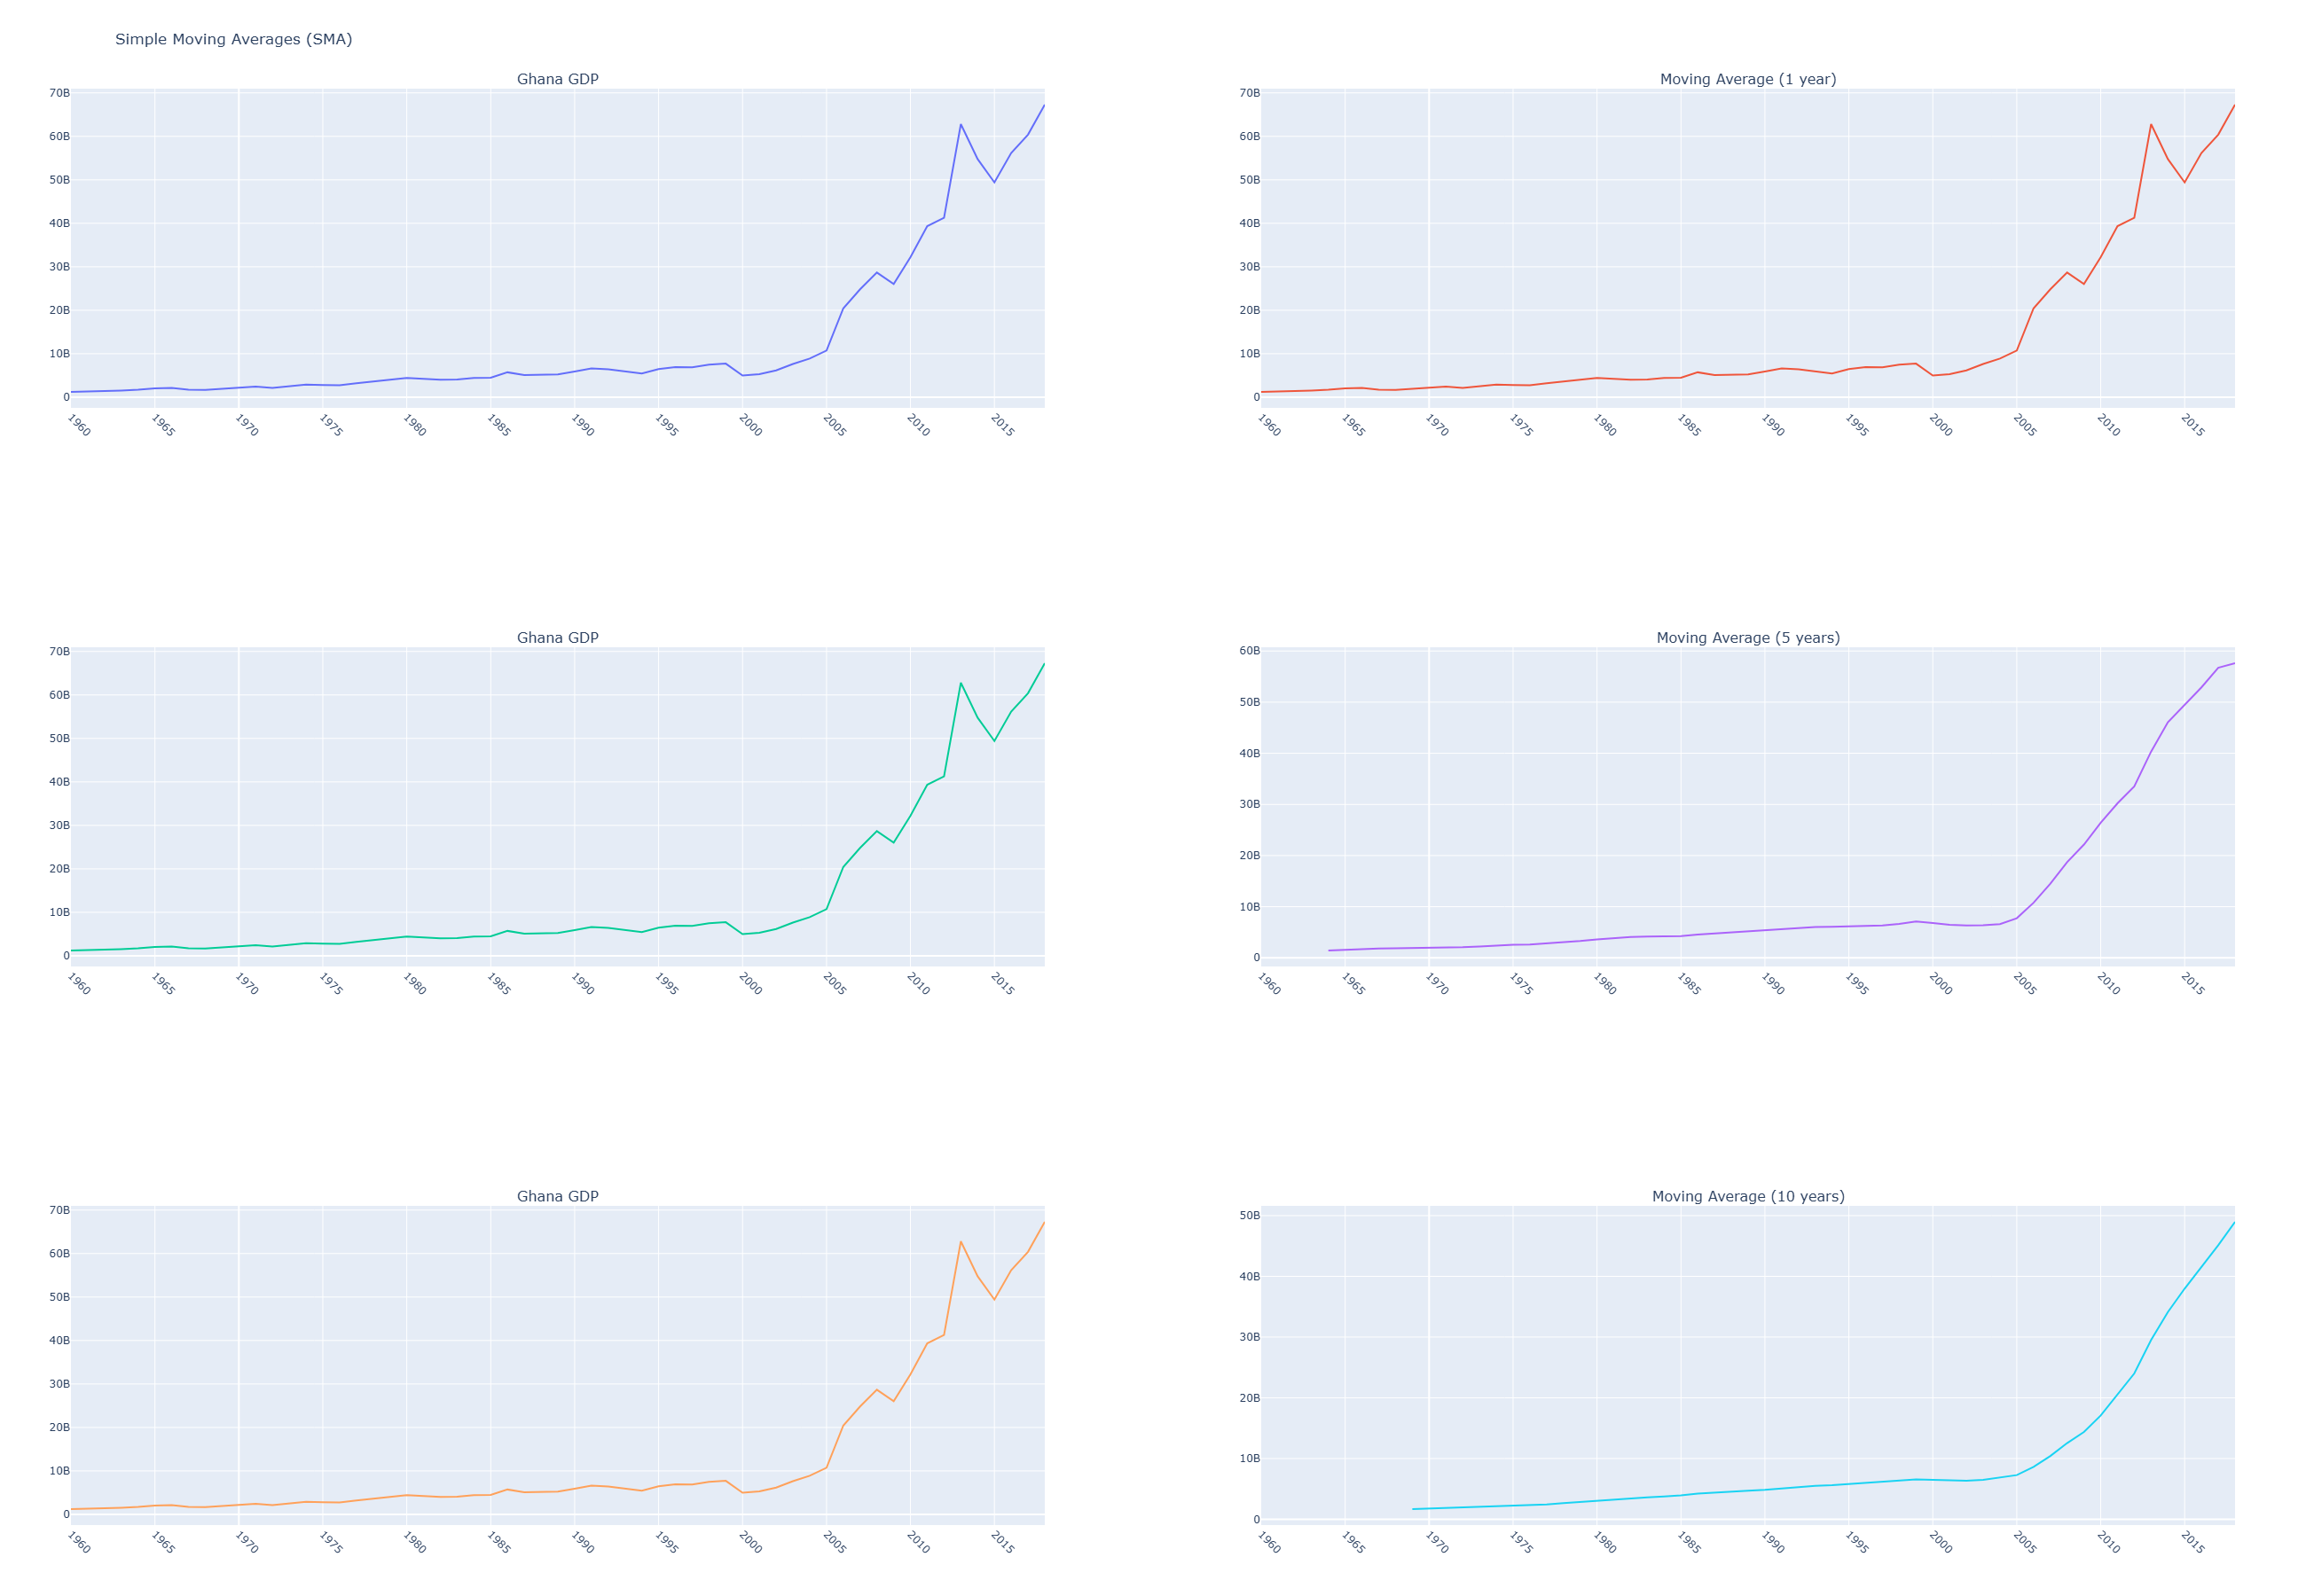

In [62]:
fig = make_subplots(
    rows=3, cols=2, 
    column_widths=[0.5, 0.5], 
    row_heights=[0.33, 0.33, 0.33],
    subplot_titles=[
        'Ghana GDP', 'Moving Average (1 year)',
        'Ghana GDP', 'Moving Average (5 years)',
        'Ghana GDP', 'Moving Average (10 years)'
    ]
)

# Добавляем оригинальные и сглаженные ряды
window_sizes = [1, 5, 10]
for i, window in enumerate(window_sizes, start=1):
    fig.add_trace(go.Scatter(y=train_ghana['GDP (current US$)'], x=train_ghana.index, showlegend=False), row=i, col=1)
    fig.add_trace(go.Scatter(y=train_ghana['GDP (current US$)'].rolling(window=window).mean(), x=train_ghana.index, showlegend=False), row=i, col=2)

# Настроим ось X с годами для нижних графиков (для всех строк)
for r in range(1, 4):
    tickvals = train_ghana.index[::5]  # метки каждые 5 лет
    ticktext = [str(date.year) for date in tickvals]
    fig.update_xaxes(
        tickmode='array',
        tickvals=tickvals,
        ticktext=ticktext,
        tickangle=45,
        row=r, col=1
    )
    fig.update_xaxes(
        tickmode='array',
        tickvals=tickvals,
        ticktext=ticktext,
        tickangle=45,
        row=r, col=2
    )
fig.update_layout(height=1800, width=2600, title_text='Simple Moving Averages (SMA)')
fig.show()


На графиках SMA виден резкий восходящий тренд ВВП с 2004, тренд прослеживается на всех окнах - 1, 5, 10 лет. Окна в 5 и 10 лет хорошо отработали, сгладив коррекцию ВВП с 2013 по 2015 года.

Данные тренда SMA подтверждены и на декомпозиции временного ряда. 

Сделаем предсказание(графически) для SMA для 3 окна.

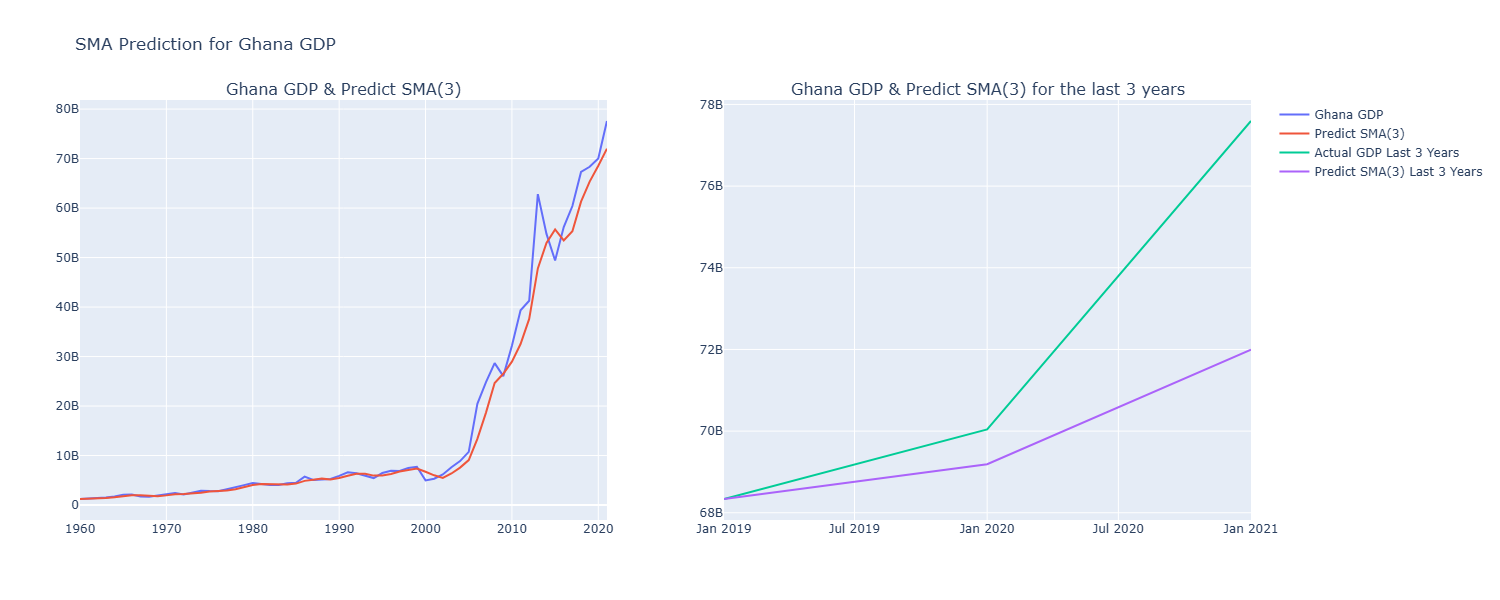

In [63]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        'Ghana GDP & Predict SMA(3)', 
        'Ghana GDP & Predict SMA(3) for the last 3 years'
    ]
)

# Делаем скользящее среднее с min_periods=1, чтобы не было NaN
ghana_gdp_y = ghana_gdp['GDP (current US$)']
ghana_gdp_sma = ghana_gdp_y.rolling(window=3, min_periods=1).mean()

# Сохраняем длину, но преобразуем индексы в строки 'YYYY-MM-DD'
ghana_gdp_x_str = ghana_gdp_y.index.strftime('%Y-%m-%d')

fig.add_trace(
    go.Scatter(
        x=ghana_gdp_x_str,
        y=ghana_gdp_y,
        mode='lines',
        name='Ghana GDP'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=ghana_gdp_x_str,
        y=ghana_gdp_sma,
        mode='lines',
        name='Predict SMA(3)'
    ),
    row=1, col=1
)

# Для второго графика берем чистые данные и тоже конвертируем индексы в строки
test_ghana_clean = test_ghana.dropna(subset=['GDP (current US$)'])
test_ghana_sma = test_ghana_clean['GDP (current US$)'].rolling(window=3, min_periods=1).mean()
test_ghana_x_str = test_ghana_clean.index.strftime('%Y-%m-%d')

fig.add_trace(
    go.Scatter(
        x=test_ghana_x_str,
        y=test_ghana_clean['GDP (current US$)'],
        mode='lines',
        name='Actual GDP Last 3 Years'
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=test_ghana_x_str,
        y=test_ghana_sma,
        mode='lines',
        name='Predict SMA(3) Last 3 Years'
    ),
    row=1, col=2
)

# Так как ось X теперь строки, не нужно указывать type='date' (Plotly не воспринимает строки как даты для date-оси)
# Можно убрать или оставить эти строки — они не повредят

fig.update_layout(
    height=600,
    width=1500,
    title_text='SMA Prediction for Ghana GDP'
)

fig.show()


Рассчитаем метрики для модели. Будем использовать MAPE и MSE.

In [64]:
MAPE = round(mean_absolute_percentage_error(test_ghana, ghana_gdp['GDP (current US$)'].rolling(window=3).mean().loc['2019-01-01':])*100, 2)
MSE = round(mean_squared_error(test_ghana, ghana_gdp['GDP (current US$)'].rolling(window=3).mean().loc['2019-01-01':])*100, 2)
print(f'MAPE for SMA = {MAPE}%')
print(f'MSE for SMA = {MSE}')

MAPE for SMA = 4.57%
MSE for SMA = 1.4175998301236838e+21


Графики SMA-предсказания показывают, что модель в целом хорошо повторяет динамику ВВП Ганы за последние 3 года (MAPE — 4,57%). Однако модель хуже предсказывает периоды резких изменений ВВП (2005–2009, 2013–2015), когда значения сильно отклонялись от среднего. Это указывает на нестационарность временного ряда.

## **3. Оценка ряда. Выбор модели**

Проверим ряд на стационарность с помощью статистического теста Дики-Фуллера

In [65]:
test = adfuller(train_ghana['GDP (current US$)'])

print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])

if test[0]> test[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  0.8030073326980115
p-value:  0.9916845572455877
Critical values:  {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
ряд нестационарен


Ряд нестационарен, поэтому дифференцируем ряд с периодом 5 для приведения к стационарности и повторяем тест:

In [66]:
df_diff_1 = train_ghana.diff(periods=5).dropna()
test = adfuller(df_diff_1['GDP (current US$)'])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -0.8168800587194958
p-value:  0.8141133234888598
Critical values:  {'1%': np.float64(-3.596635636000432), '5%': np.float64(-2.933297331821618), '10%': np.float64(-2.6049909750566895)}
ряд нестационарен


Только пятая разность позволила привести ряд к стационарности(d=5). Построим коррелограммы - частиную и полную.

In [67]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)
    
    sgt.plot_acf(series, ax = axes[0], zero=False, lags = 58)
    sgt.plot_pacf(series, ax = axes[1], method='yw', zero=False)
    plt.show()  

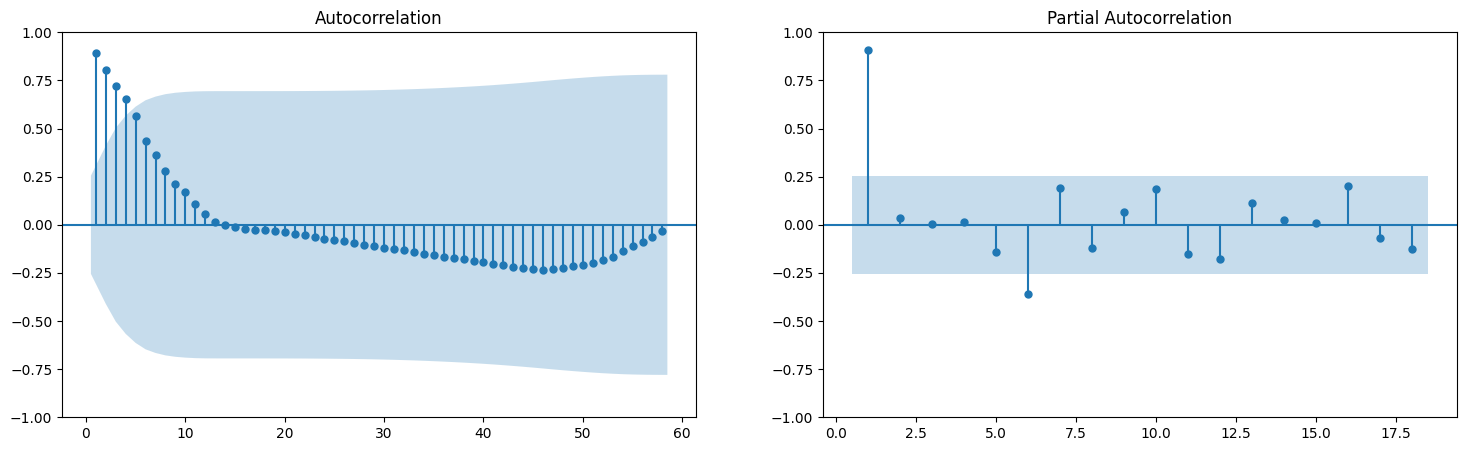

In [68]:
plot_acf_pacf(train_ghana['GDP (current US$)'])

Коррелограммы показывают, что в данных присутствуют зависимости - проявляется до 6 лаги включительно, имеется тренд. На частичной коррелограмме можно заметить выделяющийся пятый лаг(p=5).


Тест показал, что при пятом порядке интегрирования ряд ставновится стационарным. Так как ряд нестационарный, и нет необходимости учитывать экзогенные факторы, то выбирем тест **ARIMA** со следующими параметрами:

- p = 5 - кол-во лагов
- d = 5 - порядок дифференцирования
- q = 5 - порядок скользящего среднего


## **4. Построение модели. Подбор параметров**

Строим модель **ARIMA**, далее подберём оптимальные параметры для неё с помощью auto_arima.

In [69]:
arima_model = ARIMA(train_ghana, order = (5, 5, 5))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarima

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(5, 5, 5)   Log Likelihood               -1286.455
Date:                Thu, 20 Nov 2025   AIC                           2594.911
Time:                        14:21:36   BIC                           2616.789
Sample:                    01-01-1960   HQIC                          2603.348
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9492     10.631     -0.089      0.929     -21.785      19.887
ar.L2         -0.5940     15.909     -0.037      0.970     -31.775      30.587
ar.L3         -0.4540     15.967     -0.028      0.977     -31.750      30.842
ar.L4         -0.3271     13.806     -0.024      0.981     -27.387      26.733
ar.L5          0.3380     10.303      0.033      0.974     -19.855      20.531
ma.L1         -2.4797     11.346     -0.219      0.827     -24.718      19.758
ma.L2          1.3640     22.166      0.062      0.951     -42.081      44.809
ma.L3          1.4094      5.073      0.278      0.781      -8.534      11.353
ma.L4         -1.8900     14.626     -0.129      0.897     -30.556      26.776
ma.L5          0.6057      8.630      0.070      0.944     -16.308      17.520
sigma2      5.168e+19   5.07e-19   1.02e+38      0.000    5.17e+19    5.17e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                76.49
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):             215.23   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.55e+54. Standard errors may be unstable.
"""

In [70]:
smodel = pm.auto_arima(train_ghana, start_p=1, start_q=1,
                         test='adf',
                         max_p=16, max_q=20,                         
                         d=5, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True,
                         seasonal=False, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,5,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,5,0)(0,0,0)[0]             : AIC=2768.975, Time=0.01 sec
 ARIMA(1,5,0)(0,0,0)[0]             : AIC=2727.380, Time=0.01 sec
 ARIMA(0,5,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,5,0)(0,0,0)[0]             : AIC=2670.854, Time=0.01 sec
 ARIMA(3,5,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,5,1)(0,0,0)[0]             : AIC=2636.816, Time=0.04 sec
 ARIMA(3,5,1)(0,0,0)[0]             : AIC=2629.583, Time=0.06 sec
 ARIMA(4,5,1)(0,0,0)[0]             : AIC=2614.420, Time=0.14 sec
 ARIMA(4,5,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(5,5,1)(0,0,0)[0]             : AIC=2616.676, Time=0.19 sec
 ARIMA(4,5,2)(0,0,0)[0]             : AIC=2586.049, Time=0.11 sec
 ARIMA(3,5,2)(0,0,0)[0]             : AIC=2605.560, Time=0.07 sec
 ARIMA(5,5,2)(0,0,0)[0]             : AIC=2586.837, Time=0.25 sec
 ARIMA(4,5,3)(0,0,0)[0]             : AIC=2590.334, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(6, 5, 3)   Log Likelihood               -1268.798
Date:                Thu, 20 Nov 2025   AIC                           2557.595
Time:                        14:21:40   BIC                           2577.485
Sample:                    01-01-1960   HQIC                          2565.266
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4538      0.783     -1.857      0.063      -2.988       0.080
ar.L2         -1.8831      1.412     -1.334      0.182      -4.650       0.884
ar.L3         -1.7781      1.392     -1.278      0.201      -4.505       0.949
ar.L4         -1.8230      1.127     -1.617      0.106      -4.032       0.386
ar.L5         -1.3872      0.854     -1.624      0.104      -3.062       0.287
ar.L6         -0.9711      0.333     -2.914      0.004      -1.624      -0.318
ma.L1         -2.2218      0.869     -2.558      0.011      -3.924      -0.519
ma.L2          1.5641      1.863      0.839      0.401      -2.088       5.216
ma.L3         -0.3286      1.075     -0.306      0.760      -2.435       1.778
sigma2      1.741e+19   2.01e-19   8.68e+37      0.000    1.74e+19    1.74e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               120.50
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              96.76   Skew:                            -0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.3e+54. Standard errors may be unstable.
"""

Строим модель ARIMA на оптимальных параметрах - ARIMA(6,5,3):

In [71]:
arima_model_opt = ARIMA(train_ghana, order = (6, 5, 3))
arima_model_opt_fit = arima_model_opt.fit()
arima_model_opt_fit.summary()

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarima

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(6, 5, 3)   Log Likelihood               -1268.798
Date:                Thu, 20 Nov 2025   AIC                           2557.595
Time:                        14:21:40   BIC                           2577.485
Sample:                    01-01-1960   HQIC                          2565.266
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4538      0.783     -1.857      0.063      -2.988       0.080
ar.L2         -1.8831      1.412     -1.334      0.182      -4.650       0.884
ar.L3         -1.7781      1.392     -1.278      0.201      -4.505       0.949
ar.L4         -1.8230      1.127     -1.617      0.106      -4.032       0.386
ar.L5         -1.3872      0.854     -1.624      0.104      -3.062       0.287
ar.L6         -0.9711      0.333     -2.914      0.004      -1.624      -0.318
ma.L1         -2.2218      0.869     -2.558      0.011      -3.924      -0.519
ma.L2          1.5641      1.863      0.839      0.401      -2.088       5.216
ma.L3         -0.3286      1.075     -0.306      0.760      -2.435       1.778
sigma2      1.741e+19   2.01e-19   8.68e+37      0.000    1.74e+19    1.74e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               120.50
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              96.76   Skew:                            -0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.3e+54. Standard errors may be unstable.
"""

Если сравнить две модели, то модель построенная по подобранным оптимальным параметрам(ARIMA(6,5,3)) выдаёт лучшую метрику AIC=2558.008 против модели ARIMA(5,5,5) с метрикой AIC=2595.996.

Выполним для неё предсказания:

In [72]:
# создадим отдельный датафрейм с индексами первоначального 
pred_df = pd.DataFrame(index = ghana_gdp.index)
# сделаем предсказания для test_ghana и запишем в новый признак model_preds
pred_df['model_preds'] = arima_model_opt_fit.predict(start = test_ghana.index[0], end = test_ghana.index[-1])

# перенесём истинные значения в новый датафрейм
pred_df['GDP (current US$)'] = ghana_gdp['GDP (current US$)']
# формируем доверительный интервал в 95%
forecast = arima_model_opt_fit.get_forecast(len(test_ghana.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%
# добавим в датафрейм доверительный интервал для 3 последних значений
pred_df.at[test_ghana.index, 'model_preds_lower'] = forecast_df['lower GDP (current US$)']
pred_df.at[test_ghana.index, "model_preds_upper"] = forecast_df['upper GDP (current US$)']
pred_df.tail(4)

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,6.413186e+10,6.833754e+10,5.595433e+10,7.230939e+10
2020-01-01,6.997469e+10,7.004320e+10,5.640349e+10,8.354588e+10
2021-01-01,5.243957e+10,7.759428e+10,3.332030e+10,7.155883e+10


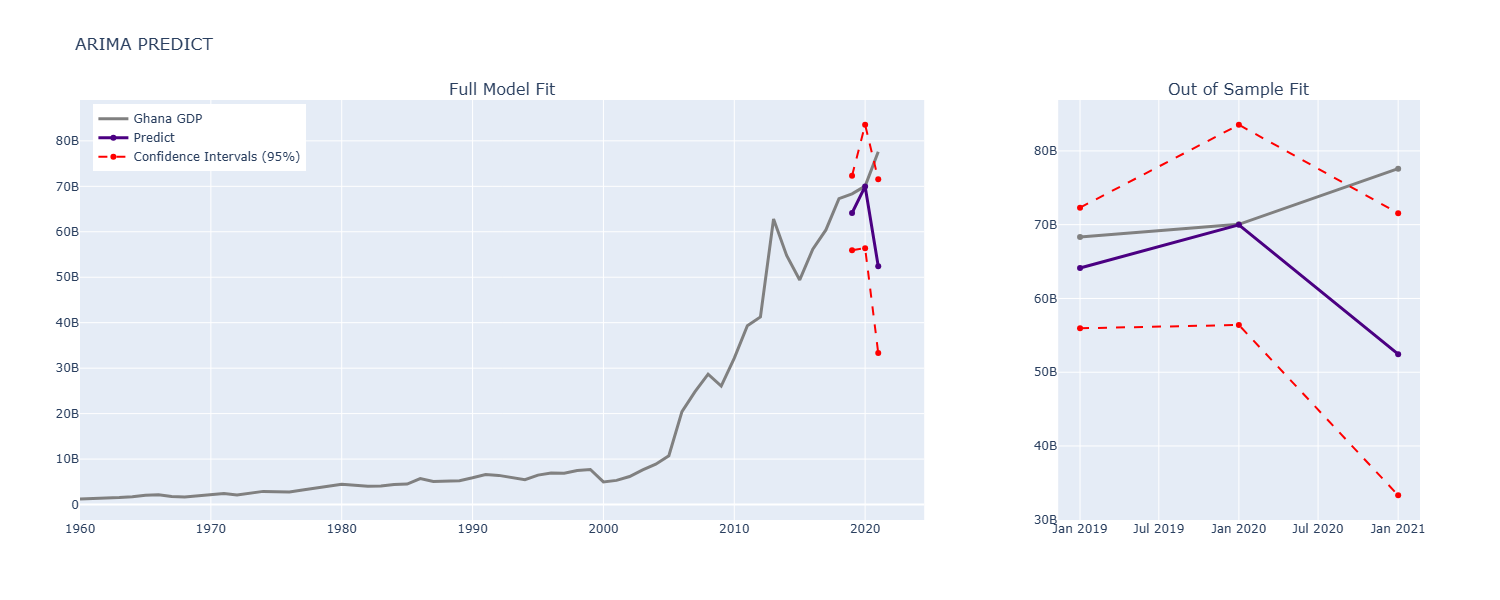

In [73]:
# Преобразуем индексы в строки формата 'YYYY-MM-DD' для корректного отображения дат
full_index_str = ghana_gdp.index.strftime('%Y-%m-%d')
test_index_str = test_ghana.index.strftime('%Y-%m-%d')

fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=['Full Model Fit', 'Out of Sample Fit'], 
    column_widths=[0.7, 0.3]
)

# Полная подгонка модели (левая панель)
fig.add_trace(
    go.Scatter(
        y=pred_df['GDP (current US$)'],
        x=full_index_str,
        showlegend=True,
        name='Ghana GDP',
        line={'color':'gray', 'width':3}
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        y=pred_df.loc[test_ghana.index]['model_preds'],
        x=test_index_str,
        showlegend=True,
        name='Predict',
        line={'color':'indigo', 'width':3}
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        y=pred_df.loc[test_ghana.index]['model_preds_lower'],
        x=test_index_str,
        showlegend=True,
        name='Confidence Intervals (95%)',
        line={'color':'red', 'width':2, 'dash':'dash'}
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        y=pred_df.loc[test_ghana.index]['model_preds_upper'],
        x=test_index_str,
        showlegend=False,
        line={'color':'red', 'width':2, 'dash':'dash'}
    ),
    row=1, col=1
)

# Вне выборки (правая панель)
fig.add_trace(
    go.Scatter(
        y=pred_df.loc[test_ghana.index]['GDP (current US$)'],
        x=test_index_str,
        showlegend=False,
        name='Ghana GDP',
        line={'color':'gray', 'width':3}
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        y=pred_df.loc[test_ghana.index]['model_preds'],
        x=test_index_str,
        showlegend=False,
        line={'color':'indigo', 'width':3}
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        y=pred_df.loc[test_ghana.index]['model_preds_lower'],
        x=test_index_str,
        showlegend=False,
        name='Confidence Intervals_lower (95%)',
        line={'color':'red', 'width':2, 'dash':'dash'}
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        y=pred_df.loc[test_ghana.index]['model_preds_upper'],
        x=test_index_str,
        showlegend=False,
        name='Confidence Intervals_upper (95%)',
        line={'color':'red', 'width':2, 'dash':'dash'}
    ),
    row=1, col=2
)

fig.update_layout(
    height=600,
    width=1500,
    title_text='ARIMA PREDICT',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.show()


In [74]:
pred_df.tail(3)

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
2019-01-01,6.413186e+10,6.833754e+10,5.595433e+10,7.230939e+10
2020-01-01,6.997469e+10,7.004320e+10,5.640349e+10,8.354588e+10
2021-01-01,5.243957e+10,7.759428e+10,3.332030e+10,7.155883e+10


In [75]:
MAPE = round(mean_absolute_percentage_error(test_ghana, pred_df['model_preds'][59:62])*100, 2)
MSE = round(mean_squared_error(test_ghana, pred_df['model_preds'][59:62])*100, 2)
print(f'MAPE for ARIMA = {MAPE}%')
print(f'MSE for ARIMA = {MSE}')

MAPE for ARIMA = 12.89%
MSE for ARIMA = 2.1681731132363314e+22


Модель ARIMA с оптимально подобранными параметрами показала следующие метрики:

- AIC = 2558.008
- MAPE for ARIMA = 12.4%
- MSE for ARIMA = 1.905126060055274e+22

На графике ARIMA PREDICT чётко видно, что истинное последнее значения GDP(за 2021) выходят за границы 95% интервала(верхней его границы), а значение за этот год предсказанное моделью расходятся порядка на 30%. Модель требует доработки.

## **5. Интерполяция. Построение модели на интерполированных данных**

Внимательно взглянем на наши данные на предмет наличия пропусков и наличия пропущенных дат:

In [76]:
ghana_gdp.asfreq(freq='AS')

C:\Users\admin\AppData\Local\Temp\ipykernel_14020\3890152194.py:1: FutureWarning:

'AS' is deprecated and will be removed in a future version, please use 'YS' instead.



,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [77]:
ghana_gdp.isnull().sum()

GDP (current US$)    0
dtype: int64

На первый взгляд пропущенных значений нет, но иногда пропуски в данных могут быть заполнены нулями. 

Сделаем проверку на наличие нулевых значений и в случае нахождения замените их на NaN.

In [78]:
ghana_gdp[ghana_gdp['GDP (current US$)']==0]

,GDP (current US$)
year,


In [79]:
ghana_gdp['GDP (current US$)'] = ghana_gdp['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

Теперь выполним заполнение пропуска за 1961-01-01 методом интерполяции:

In [80]:
ghana_gdp['GDP (current US$)'] = ghana_gdp['GDP (current US$)'].interpolate(method='linear')

In [81]:
train_ghana = ghana_gdp.loc[:'2018-12-31']
test_ghana = ghana_gdp.loc['2019-01-01':]
train_ghana.shape, test_ghana.shape

((59, 1), (3, 1))

Вновь проверим ряд на стационарность.

In [82]:
test = adfuller(train_ghana['GDP (current US$)'])

print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])

if test[0]> test[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  0.8030073326980115
p-value:  0.9916845572455877
Critical values:  {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
ряд нестационарен


Ряд также нестационарен. Проведём его дифференцирование.

In [83]:
df_diff_1 = train_ghana.diff(periods=2).dropna()
test = adfuller(df_diff_1['GDP (current US$)'])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -3.99980344094915
p-value:  0.0014115408436661263
Critical values:  {'1%': np.float64(-3.584828853223594), '5%': np.float64(-2.9282991495198907), '10%': np.float64(-2.6023438271604937)}
ряд стационарен


После второго порядка дифференцирования(d=2) ряд стал стационарным. 

Взглянем на коррелограмму:

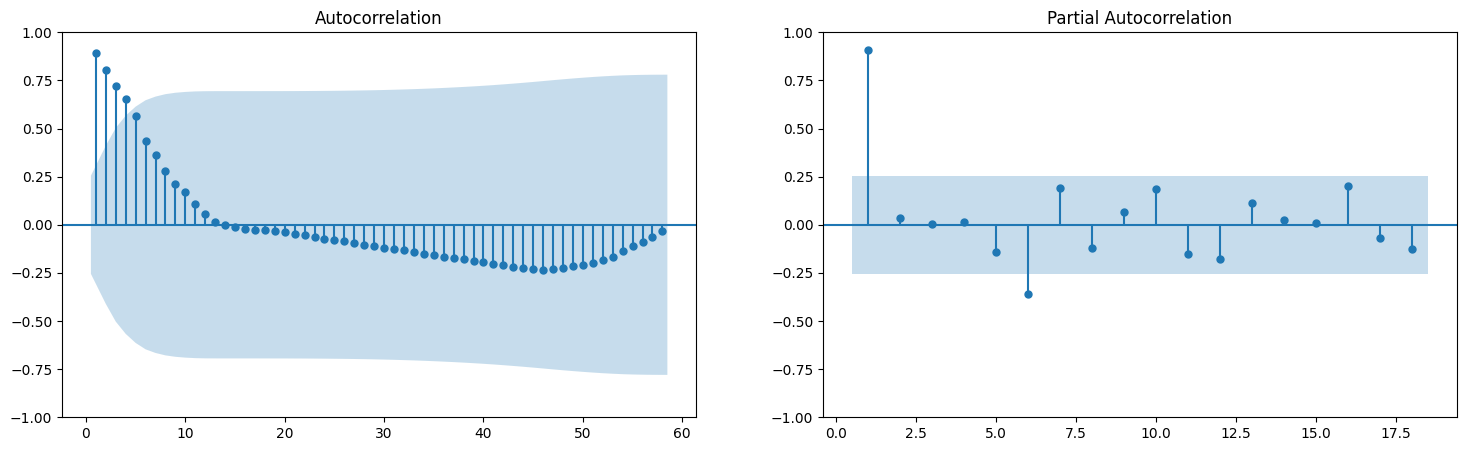

In [84]:
plot_acf_pacf(train_ghana['GDP (current US$)'])

На частичной коррелограмме отчётливо выделяется пятый лаг(p=5), на полной коррелограмме видим корреляцию до 4 лага.

Построим модель ARIMA по интерполированным данным с параметрами:

- p=5
- d=2
- q=3

In [85]:
arima_model = ARIMA(train_ghana, order = (5, 2, 3))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarima

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(5, 2, 3)   Log Likelihood               -1328.224
Date:                Thu, 20 Nov 2025   AIC                           2674.448
Time:                        14:21:43   BIC                           2692.835
Sample:                    01-01-1960   HQIC                          2681.594
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4680      0.247     -1.891      0.059      -0.953       0.017
ar.L2         -0.0416      0.233     -0.178      0.858      -0.499       0.416
ar.L3         -0.3521      0.301     -1.169      0.242      -0.942       0.238
ar.L4         -0.4446      0.320     -1.390      0.164      -1.072       0.182
ar.L5         -0.0149      0.371     -0.040      0.968      -0.743       0.713
ma.L1         -0.5476      0.338     -1.622      0.105      -1.209       0.114
ma.L2         -0.6445      0.274     -2.349      0.019      -1.182      -0.107
ma.L3          0.8387      0.170      4.937      0.000       0.506       1.172
sigma2      1.205e+19   6.22e-20   1.94e+38      0.000     1.2e+19     1.2e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                71.30
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             328.82   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.66e+53. Standard errors may be unstable.
"""

Далее подберём оптимальные параметры:

In [86]:
smodel = pm.auto_arima(train_ghana, start_p=1, start_q=1,
                         test='adf',
                         max_p=16, max_q=20,                         
                         d=2, max_d=5, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True,
                         seasonal=False, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Thu, 20 Nov 2025   AIC                           2680.513
Time:                        14:21:44   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.99e+55. Standard errors may be unstable.
"""

Итак, оптимальные параметры ARIMA(1,2,3) - построим и обучим модель на них и сделаем предсказания для тестовой выборки.

In [87]:
arima_model_opt = ARIMA(train_ghana, order = (1, 2, 3))
arima_model_opt_fit = arima_model_opt.fit()
arima_model_opt_fit.summary()

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarima

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Thu, 20 Nov 2025   AIC                           2680.513
Time:                        14:21:44   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.99e+55. Standard errors may be unstable.
"""

In [88]:
# создадим отдельный датафрейм с индексами первоначального 
pred_df = pd.DataFrame(index = ghana_gdp.index)
# сделаем предсказания для test_ghana и запишем в новый признак model_preds
pred_df['model_preds'] = arima_model_opt_fit.predict(start = test_ghana.index[0], end = test_ghana.index[-1])

# перенесём истинные значения в новый датафрейм
pred_df['GDP (current US$)'] = ghana_gdp['GDP (current US$)']
# формируем доверительный интервал в 95%
forecast = arima_model_opt_fit.get_forecast(len(test_ghana.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%
# добавим в датафрейм доверительный интервал для 3 последних значений
pred_df.at[test_ghana.index, 'model_preds_lower'] = forecast_df['lower GDP (current US$)']
pred_df.at[test_ghana.index, "model_preds_upper"] = forecast_df['upper GDP (current US$)']
pred_df.tail(4)

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,6.781359e+10,6.833754e+10,5.934528e+10,7.628189e+10
2020-01-01,7.249485e+10,7.004320e+10,6.044242e+10,8.454729e+10
2021-01-01,7.509393e+10,7.759428e+10,6.145217e+10,8.873569e+10


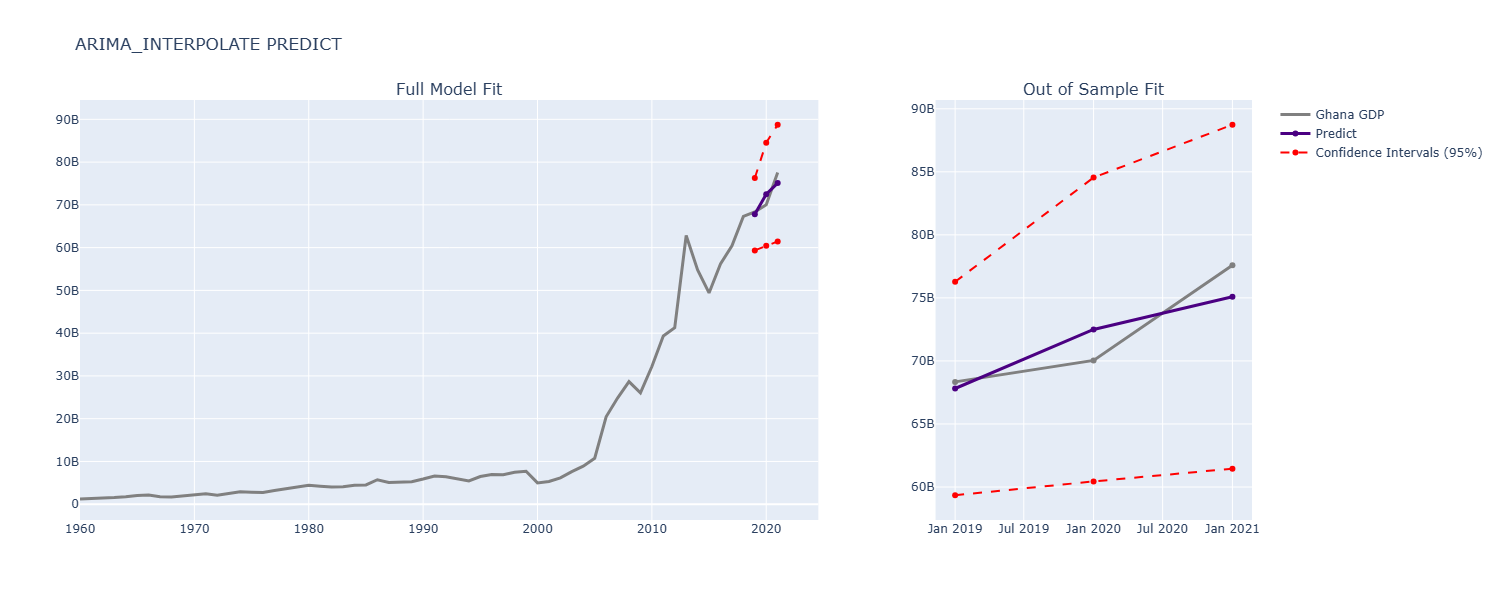

In [89]:
# Преобразуем индексы в строки для корректного отображения оси времени
full_index_str = ghana_gdp.index.strftime('%Y-%m-%d')
test_index_str = test_ghana.index.strftime('%Y-%m-%d')

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Full Model Fit', 'Out of Sample Fit'],
    column_widths=[0.7, 0.3]  # используем относительные доли
)

# Левая часть — полное соответствие модели
fig.add_trace(go.Scatter(
    y=pred_df['GDP (current US$)'],
    x=full_index_str,
    showlegend=True,
    name='Ghana GDP',
    line={'color': 'gray', 'width': 3}
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds'],
    x=test_index_str,
    showlegend=True,
    name='Predict',
    line={'color': 'indigo', 'width': 3}
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds_lower'],
    x=test_index_str,
    showlegend=True,
    name='Confidence Intervals (95%)',
    line={'color': 'red', 'width': 2, 'dash': 'dash'}
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds_upper'],
    x=test_index_str,
    showlegend=False,
    line={'color': 'red', 'width': 2, 'dash': 'dash'}
), row=1, col=1)

# Правая часть — прогноз вне выборки
fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['GDP (current US$)'],
    x=test_index_str,
    showlegend=False,
    name='Ghana GDP',
    line={'color': 'gray', 'width': 3}
), row=1, col=2)

fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds'],
    x=test_index_str,
    showlegend=False,
    line={'color': 'indigo', 'width': 3}
), row=1, col=2)

fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds_lower'],
    x=test_index_str,
    showlegend=False,
    name='Confidence Intervals_lower (95%)',
    line={'color': 'red', 'width': 2, 'dash': 'dash'}
), row=1, col=2)

fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds_upper'],
    x=test_index_str,
    showlegend=False,
    name='Confidence Intervals_upper (95%)',
    line={'color': 'red', 'width': 2, 'dash': 'dash'}
), row=1, col=2)

fig.update_layout(
    height=600,
    width=1500,
    title_text='ARIMA_INTERPOLATE PREDICT'
)

fig.show()


In [90]:
pred_df.tail(3)

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
2019-01-01,6.781359e+10,6.833754e+10,5.934528e+10,7.628189e+10
2020-01-01,7.249485e+10,7.004320e+10,6.044242e+10,8.454729e+10
2021-01-01,7.509393e+10,7.759428e+10,6.145217e+10,8.873569e+10


In [91]:
MAPE = round(mean_absolute_percentage_error(test_ghana, pred_df['model_preds'][59:62])*100, 2)
MSE = round(mean_squared_error(test_ghana, pred_df['model_preds'][59:62])*100, 2)
print(f'MAPE for ARIMA_INTERPOLATE = {MAPE}%')
print(f'MSE for ARIMA_INTERPOLATE = {MSE}')

MAPE for ARIMA_INTERPOLATE = 2.5%
MSE for ARIMA_INTERPOLATE = 4.178956400072073e+20


Построенная модель ARIMA_INTERPOLATE на интерполированных данных несмотря на незначительно выше показатель AIC=2680.513(против ARIMA c AIC= 2558.008) хорошо себя показала на тестовых данных - истинные значения входят в построенный 95% доверительный интервал. Метрики MSE и MAPE выше, чем у моделей SMA и ARIMA:

- MAPE for ARIMA_INTERPOLATE = 2.5%
- MSE for ARIMA_INTERPOLATE = 4.178956426388931e+20

## **6. Предсказание волатильности. Модели прогнозирования гетероскедастичности.**

Рассчитаем волатильность временного ряда(в %), добавим их данные в исходный датафрейм в виде GDP_vol:

In [92]:
ghana_gdp['GDP_vol'] = ghana_gdp['GDP (current US$)'].pct_change(1).mul(100).abs()
ghana_gdp['GDP_vol'].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_vol, dtype: float64

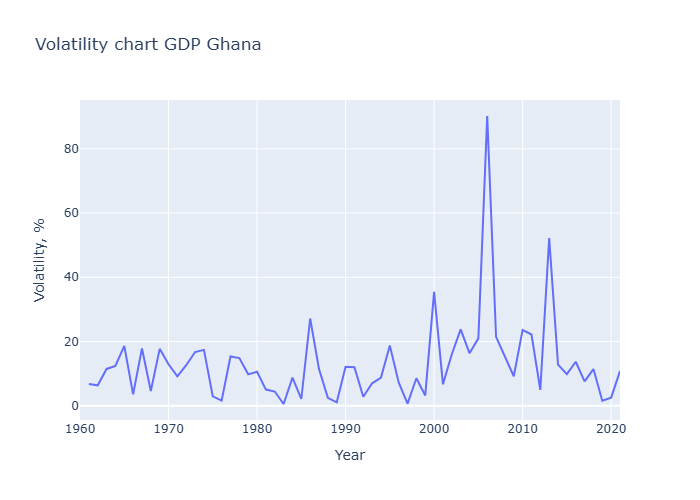

In [93]:
fig = px.line(
    x=ghana_gdp.index.strftime('%Y-%m-%d'),  # конвертируем дату в строку
    y=ghana_gdp['GDP_vol'],
    labels={'x': 'Year', 'y': 'Volatility, %'},
    title='Volatility chart GDP Ghana'
)

fig.show()


Сразу проверим ряд на **гетероскедастичность** т.е. на неоднородность наблюдений, выражающаяся в неодинаковой дисперсии. Для этого создадим вспомогательный признак GDP_vol_sqr, где будут находиться квадраты значений и отразим их на графике.

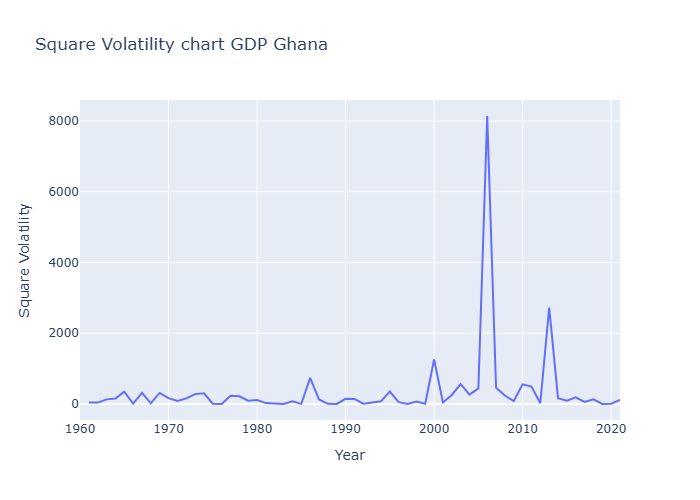

In [94]:
ghana_gdp['GDP_vol_sqr'] = ghana_gdp['GDP_vol'].apply(lambda x: x**2)

fig = px.line(
    x=ghana_gdp.index.strftime('%Y-%m-%d'),  # преобразуем даты в строки
    y=ghana_gdp['GDP_vol_sqr'],
    labels={'x': 'Year', 'y': 'Square Volatility'},
    title='Square Volatility chart GDP Ghana'
)

fig.show()


Volatility chart GDB Ghana на всём своём периоде наблюдения характеризуется стабильной волатильностью в коридоре 20%(особенно в период 1960-1999) с выделением нескольких резких пиков:

- 1986 - в 27%
- 2000 - в 35%
- 2006 - в 90%
- 2013 - в 52%

Square Volatility chart GDB Ghana говорит о **гомоскедастичности** ряда - на всём протяжении показатели околонулевые, за исключением ранее упомянутых пиков.

Вновь разобьём данные на тестовые и тренировочные и выполним декомпозицию временного ряда:

In [95]:
train_ghana = ghana_gdp.loc[:'2018-12-31']
test_ghana = ghana_gdp.loc['2019-01-01':]
train_ghana.shape, test_ghana.shape

((59, 3), (3, 3))

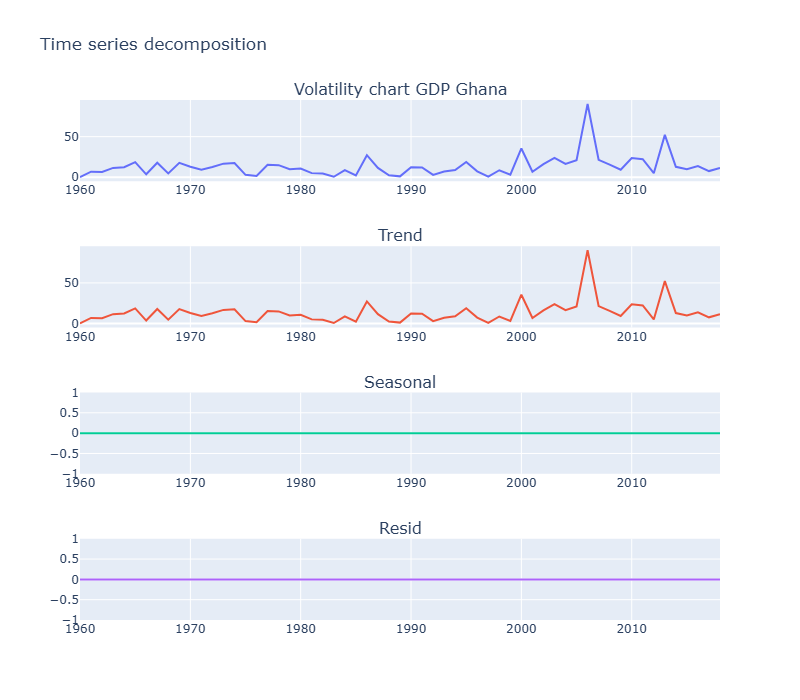

In [96]:
# Заполняем пропуски и преобразуем даты в строки
x_str = train_ghana.index.strftime('%Y-%m-%d')
y_vol = train_ghana['GDP_vol'].fillna(0)

result = seasonal_decompose(y_vol, model='additive')

fig = make_subplots(
    rows=4, cols=1,
    row_heights=[50, 50, 50, 50],
    subplot_titles=['Volatility chart GDP Ghana', 'Trend', 'Seasonal', 'Resid']
)

fig.add_trace(go.Scatter(y=y_vol, x=x_str, showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(y=result.trend, x=x_str, showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(y=result.seasonal, x=x_str, showlegend=False), row=3, col=1)
fig.add_trace(go.Scatter(y=result.resid, x=x_str, showlegend=False), row=4, col=1)

fig.update_layout(height=700, width=800, title_text='Time series decomposition')
fig.show()


Декомпозиция временного ряда сезонности(цикличности) или шума не выявила, тренд отсутсвует.

Построим коррелограммы волатильности:

In [97]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)
    
    sgt.plot_acf(series, ax = axes[0], zero=False, lags = 57)
    sgt.plot_pacf(series, ax = axes[1], method='yw', zero=False)
    plt.show()  

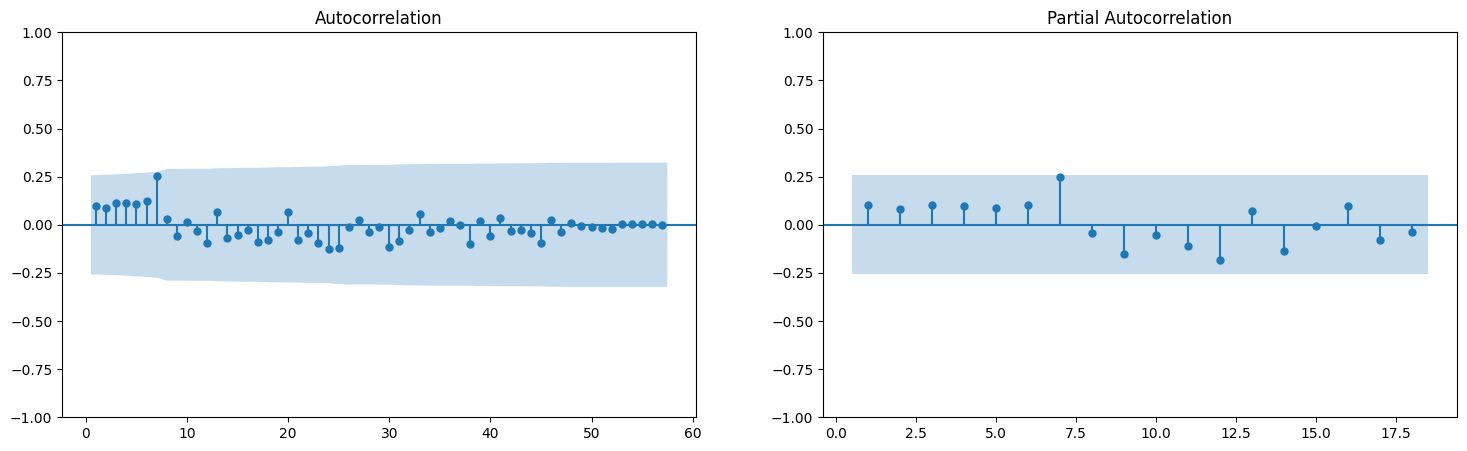

In [98]:
plot_acf_pacf(train_ghana['GDP_vol'][1:])

На графиках коррелограмм видно практически отсутствующую корреляцию со слабо выделяющимся шестым лагом, что говорит об отсутсвии тренда и цикличной составляющей.

Проверим ряд на стационарность.

In [99]:
test = adfuller(train_ghana['GDP_vol'][1:])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': np.float64(-3.5506699942762414), '5%': np.float64(-2.913766394626147), '10%': np.float64(-2.5946240473991997)}
ряд стационарен


Будем использовать GARCH-модель для предсказания волатильности.

In [100]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(ghana_gdp['GDP_vol'].loc[ghana_gdp.index]) 

from arch import arch_model
model = arch_model(garch_df['GDP_vol'].dropna(), p = 6, q = 1, vol = "GARCH")

# в параметре last_obs указываем последний объект, до которого будем совершать обучение. 
# в нашем случае это до первого объекта из test выборки 

model_results = model.fit(last_obs = test_ghana.index[0], update_freq = 5)

model_results.summary()

Iteration:      5,   Func. Count:     59,   Neg. LLF: 220.0682255186633
Iteration:     10,   Func. Count:    113,   Neg. LLF: 214.50075278290194
Iteration:     15,   Func. Count:    164,   Neg. LLF: 214.4040845548423
Iteration:     20,   Func. Count:    214,   Neg. LLF: 214.31062291718945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.31061699233626
            Iterations: 22
            Function evaluations: 233
            Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.311
Distribution:                  Normal   AIC:                           446.621
Method:            Maximum Likelihood   BIC:                           465.165
                                        No. Observations:                   58
Date:                Thu, Nov 20 2025   Df Residuals:                       57
Time:                        14:21:53   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.2445      1.422      7.909  2.592e-15 [  8.458, 14.031]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         26.5259     29.361      0.903      0.366      [-31.020, 84.071]
alpha[1]       0.0000  1.041e-02      0.000      1.000 [-2.041e-02,2.041e-02]
alpha[2]       0.0000  1.710e-02      0.000      1.000 [-3.351e-02,3.351e-02]
alpha[3]       0.2560      0.754      0.340      0.734      [ -1.222,  1.734]
alpha[4]   6.0587e-12  8.016e-02  7.558e-11      1.000      [ -0.157,  0.157]
alpha[5]       0.0000  1.051e-02      0.000      1.000 [-2.060e-02,2.060e-02]
alpha[6]       0.6731      0.391      1.724  8.478e-02   [-9.230e-02,  1.439]
beta[1]        0.0709  8.247e-02      0.859      0.390   [-9.078e-02,  0.233]
=============================================================================

Covariance estimator: robust
"""

Сделаем предсказания и визуализиуем результат.

In [101]:
predictions_df = test_ghana.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_ghana.index]

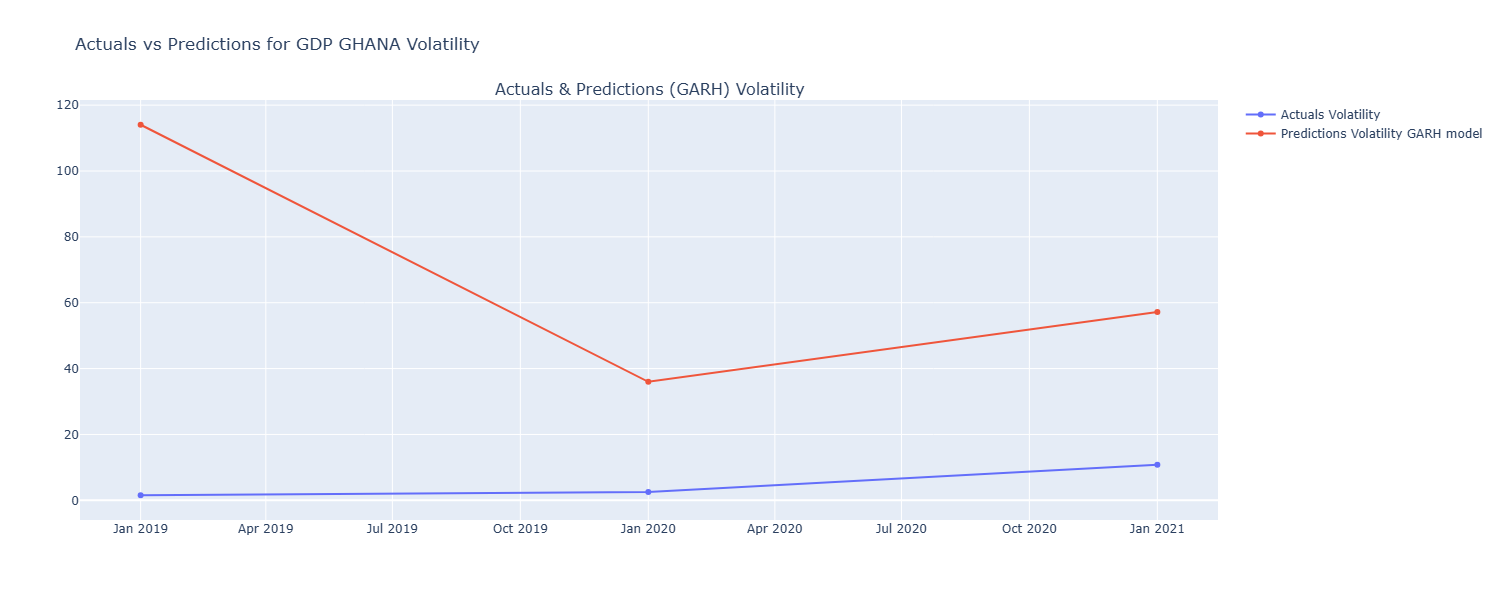

In [102]:
# Преобразуем индекс test_ghana в строки
test_index_str = test_ghana.index.strftime('%Y-%m-%d')

fig = make_subplots(
    rows=1, cols=1,
    subplot_titles=['Actuals & Predictions (GARH) Volatility']
)

fig.add_trace(go.Scatter(
    y=predictions_df["GDP_vol"].abs(),
    x=test_index_str,
    showlegend=True,
    name='Actuals Volatility'
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=predictions_df["Predictions"],
    x=test_index_str,
    showlegend=True,
    name='Predictions Volatility GARH model'
), row=1, col=1)

fig.update_layout(
    height=600,
    width=1500,
    title_text='Actuals vs Predictions for GDP GHANA Volatility'
)

fig.show()


In [103]:
MAPE = round(mean_absolute_percentage_error(predictions_df["GDP_vol"].abs(), predictions_df["Predictions"])*100, 2)
MSE = round(mean_squared_error(predictions_df["GDP_vol"].abs(), predictions_df["Predictions"])*100, 2)
print(f'MAPE for GARCH = {MAPE}%')
print(f'MSE for GARCH = {MSE}')

MAPE for GARCH = 3021.48%
MSE for GARCH = 530989.65


Теперь сделаем модель на основе линейной регрессии.

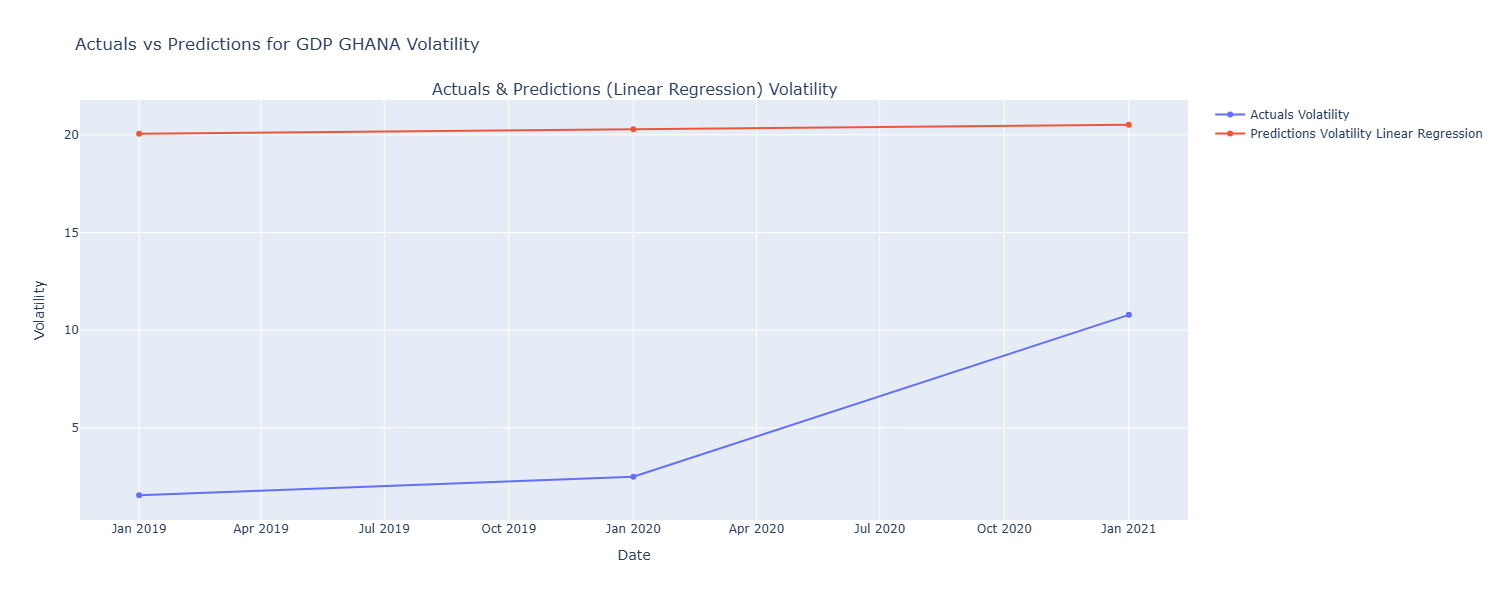

In [111]:
X_train = pd.DataFrame(range(ghana_gdp['GDP_vol'].shape[0]))[:train_ghana.shape[0]].fillna(0)
X_test = pd.DataFrame(range(ghana_gdp['GDP_vol'].shape[0]))[train_ghana.shape[0]:].fillna(0)
y_train = train_ghana['GDP_vol'].fillna(0)
y_test = test_ghana['GDP_vol'].fillna(0)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

# Преобразуем индекс y_test в строки
x_str = y_test.index.strftime('%Y-%m-%d')

fig = make_subplots(
    rows=1, cols=1,
    subplot_titles=['Actuals & Predictions (Linear Regression) Volatility']
)

fig.add_trace(go.Scatter(
    y=y_test,
    x=x_str,
    showlegend=True,
    name='Actuals Volatility'
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=lr_predict,
    x=x_str,
    showlegend=True,
    name='Predictions Volatility Linear Regression'
), row=1, col=1)

fig.update_layout(
    height=600,
    width=1500,
    title_text='Actuals vs Predictions for GDP GHANA Volatility',
    xaxis_title='Date',
    yaxis_title='Volatility'
)

fig.show()



In [112]:
MAPE = round(mean_absolute_percentage_error(y_test, lr_predict)*100, 2)
MSE = round(mean_squared_error(y_test, lr_predict)*100, 2)
print(f'MAPE for LinearRegression_Volatility= {MAPE}%')
print(f'MSE for LinearRegression_Volatility = {MSE}')

MAPE for LinearRegression_Volatility= 667.81%
MSE for LinearRegression_Volatility = 25140.89


Судя по графику, модель GARCH не смогла адекватно уловить дисперсию, так как подобное поведение было новым и не встречалось в обучающей выборке. Ранее мы установили, что ряд является гомоскедастичным и характеризуется слабой вариацией на протяжении всего периода (за исключением четырёх выбросов). Поэтому GARCH показала низкую эффективность, уступая даже линейной регрессии — метрики которой в 20 раз лучше. Это объясняется тем, что GARCH рассчитана на моделирование изменений дисперсии во времени и чувствительна к сильным колебаниям, которые в нашем ряде отсутствуют.

## **7. PROPHET**

Prophet — это метод прогнозирования данных временных рядов на основе AR-модели, в которой учтены годовая, еженедельная и ежедневная сезонности, а также эффекты праздничных дней.

In [113]:
ghana_gdp_zip = pd.read_csv('C:/Users/admin/Desktop/$/DS_education/math ml 13/ghana_gdp.zip', index_col=['year'], parse_dates=['year'])
ghana_gdp = ghana_gdp_zip.copy()
ghana_gdp.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Преобразуем данные - датасет должен состоять из 2 признаков:

- Столбец DS (отметка даты) должен иметь временной формат (DateTime), например ГГГГ-ММ-ДД — для даты или ГГГГ-ММ-ДД ЧЧ:ММ:СС — для отметки времени.
- Столбец Y должен быть числовым и представлять измерение, которое мы хотим спрогнозировать.

In [114]:
ghana_gdp['ds'] = ghana_gdp.index
ghana_gdp['y'] = ghana_gdp['GDP (current US$)']
ghana_gdp = ghana_gdp.reset_index()
ghana_gdp = ghana_gdp.drop(['year', 'GDP (current US$)'], axis=1)
ghana_gdp.head()

,ds,y
0,1960-01-01,1.217087e+09
1,1961-01-01,0.000000e+00
2,1962-01-01,1.382353e+09
3,1963-01-01,1.540616e+09
4,1964-01-01,1.731092e+09


In [115]:
# разделим датасет на тестовый и тренировочный
train_ghana = ghana_gdp[ghana_gdp['ds'] < '2018-12-31']
test_ghana = ghana_gdp[ghana_gdp['ds'] > '2018-12-31']
train_ghana.shape, test_ghana.shape

((59, 2), (3, 2))

In [116]:
model = Prophet()
model.fit(train_ghana)
forecast_df = model.predict(test_ghana)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO	Task(Task-3) prophet:forecaster.py:parse_seasonality_args()- Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO	Task(Task-3) prophet:forecaster.py:parse_seasonality_args()- Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2019-01-01,3.673415e+10,2.293173e+10,5.150526e+10
1,2020-01-01,3.708702e+10,2.283907e+10,5.113870e+10
2,2021-01-01,3.933184e+10,2.450953e+10,5.372260e+10


В результате построения прогноза каждому DS будет присвоено прогнозируемое значение (YHAT). Также в прогнозном датафрейме будут два новых столбца ('yhat_lower', 'yhat_upper'), в которых будут находиться верхняя и нижняя границы доверительного интервала.

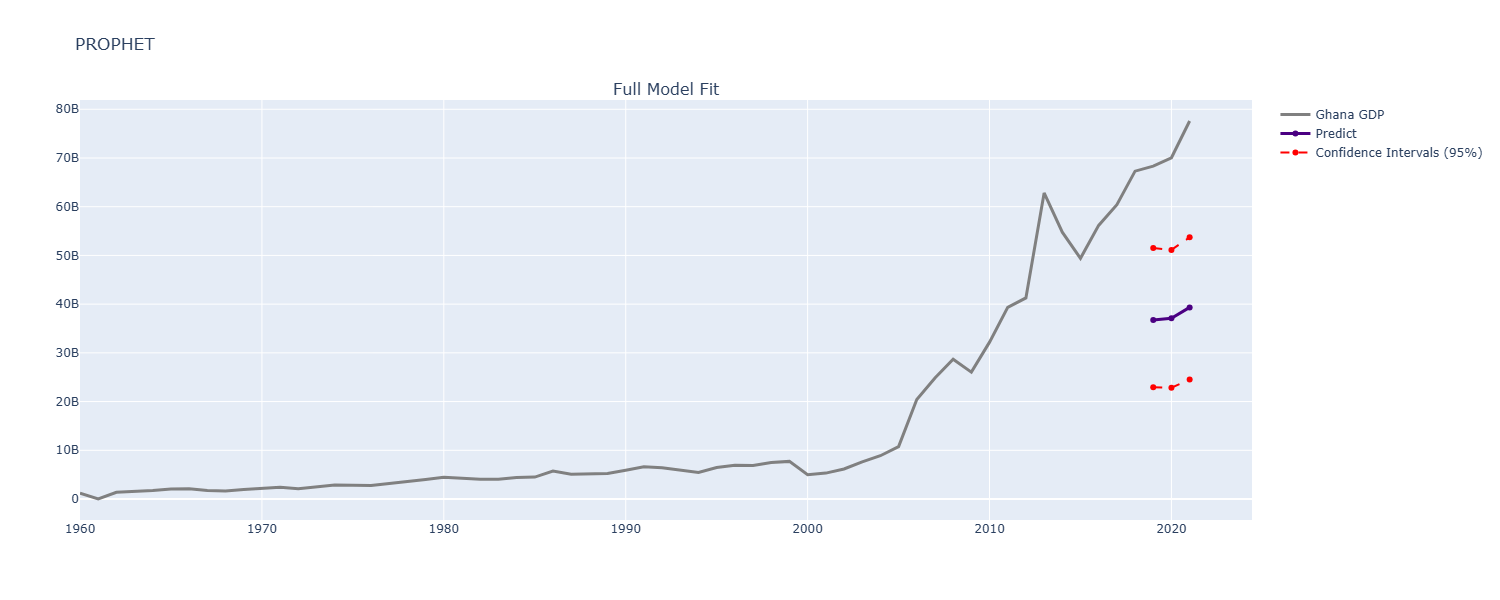

In [117]:
# Преобразуем даты в строковый формат
ghana_gdp_zip_dates = ghana_gdp_zip.index.strftime('%Y-%m-%d')
forecast_dates = forecast_df['ds'].dt.strftime('%Y-%m-%d')

fig = make_subplots(
    rows=1, cols=1,
    subplot_titles=['Full Model Fit']
)

fig.add_trace(go.Scatter(
    y=ghana_gdp_zip['GDP (current US$)'],
    x=ghana_gdp_zip_dates,
    showlegend=True,
    name='Ghana GDP',
    line={'color':'gray', 'width':3}
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=forecast_df['yhat'],
    x=forecast_dates,
    showlegend=True,
    name='Predict',
    line={'color':'indigo', 'width':3}
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=forecast_df['yhat_lower'],
    x=forecast_dates,
    showlegend=True,
    name='Confidence Intervals (95%)',
    line={'color':'red', 'width':2, 'dash':'dash'}
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=forecast_df['yhat_upper'],
    x=forecast_dates,
    showlegend=False,
    name='Confidence Intervals (95%)',
    line={'color':'red', 'width':2, 'dash':'dash'}
), row=1, col=1)

fig.update_layout(
    height=600,
    width=1500,
    title_text='PROPHET'
)

fig.show()


In [118]:
MAPE = round(mean_absolute_percentage_error(test_ghana['y'], forecast_df['yhat']) * 100, 2)
MSE = round(mean_squared_error(test_ghana['y'], forecast_df['yhat']) * 100, 2)
print(f'MAPE for Prophet= {MAPE}%')
print(f'MSE for Prophet = {MSE}')

MAPE for Prophet= 47.54%
MSE for Prophet = 1.182966203921586e+23


Очевидно, что предсказания модели Prophet существенно расходятся с реальными значениями ВВП и не попадают в доверительный интервал. Это объясняется тем, что Prophet наиболее эффективен для временных рядов с выраженной сезонностью и большим количеством сезонных циклов, тогда как в нашем случае сезонность отсутствует, что снижает качество прогноза.

## **8. Итоги**

В ходе анализа ВВП Ганы за 62 года (с 1960 по 2021 гг.) было выявлено следующее:

- График ВВП показал восходящий тренд, начавшийся с 2004 года. В период с 1960 по 2004 ВВП увеличился всего в 3 раза, демонстрируя очень медленный рост. Ряд не содержит сезонности или цикличности, шум близок к нулю. Эти выводы подтверждены моделями скользящего среднего (SMA) с разными окнами.

- Проведённые тесты выявили нестационарность ряда, что обоснованно повысило актуальность использования модели ARIMA.

- В данных обнаружен пропуск за 1961 год (значение равно нулю), который был обработан методом интерполяции. После этого модель ARIMA была повторно построена на интерполированных данных. Оптимальные параметры подбирались с помощью функции auto_arima. На интерполированных данных удалось улучшить показатели качества: MAPE составила 2,5%, MAE также снизилась.

- Проведён анализ волатильности ВВП. Волатильность оказалась стационарной и гомоскедастичной с низкой дисперсией (не выше 20%) за исключением 4 резких пиков:
  - 1986: 27%
  - 2000: 35%
  - 2006: 90%
  - 2013: 52%

- Построенная модель GARCH для прогнозирования волатильности не оправдала ожиданий — она не уловила зависимость дисперсии. Временной ряд не содержит тренда и сезонности, что подтвердили слабые корреляции лагов на коррелограммах. В сравнении с линейной регрессией модель показала худшие результаты.

- Для эксперимента была построена модель Prophet, которая также не подошла из-за отсутствия сезонности и цикличности в данных.

---

В итоге была выбрана модель ARIMA(1,2,3) на интерполированных данных с оптимальными параметрами. Следующим шагом станет прогноз ВВП Ганы на 2022 год с последующим сравнением с фактическими данными за 2023 год.

In [119]:
ghana_gdp_zip = pd.read_csv('C:/Users/admin/Desktop/$/DS_education/math ml 13/ghana_gdp.zip', index_col=['year'], parse_dates=['year'])
ghana_gdp = ghana_gdp_zip.copy()
ghana_gdp.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [120]:
ghana_gdp['GDP (current US$)'] = ghana_gdp['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
ghana_gdp['GDP (current US$)'] = ghana_gdp['GDP (current US$)'].interpolate(method='linear')

In [121]:
gdp_2022 = pd.DataFrame(index=[pd.to_datetime('2022-01-01')], columns=['GDP (current US$)'])
ghana_gdp_new = pd.concat([ghana_gdp, gdp_2022], axis=0)
ghana_gdp_new.tail(4)

C:\Users\admin\AppData\Local\Temp\ipykernel_14020\1425217718.py:2: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,GDP (current US$)
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10
2022-01-01,NaN


In [122]:
train_ghana = ghana_gdp_new.loc[:'2018-12-31']
test_ghana = ghana_gdp_new.loc['2018-12-31':]
train_ghana.shape, test_ghana.shape

((59, 1), (4, 1))

In [123]:
arima_model = ARIMA(train_ghana, order = (1, 2, 3))
arima_model_fit = arima_model_opt.fit()
arima_model_fit.summary()

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarima

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Thu, 20 Nov 2025   AIC                           2680.513
Time:                        14:36:17   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.99e+55. Standard errors may be unstable.
"""

In [124]:
smodel = pm.auto_arima(train_ghana, start_p=1, start_q=1,
                         test='adf',
                         max_p=16, max_q=20,                         
                         d=2, max_d=5, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True,
                         seasonal=False, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.01 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Thu, 20 Nov 2025   AIC                           2680.513
Time:                        14:36:22   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.99e+55. Standard errors may be unstable.
"""

In [125]:
arima_model_opt = ARIMA(train_ghana, order = (1, 2, 3))
arima_model_opt_fit = arima_model_opt.fit()
arima_model_opt_fit.summary()

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarima

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Thu, 20 Nov 2025   AIC                           2680.513
Time:                        14:36:26   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.99e+55. Standard errors may be unstable.
"""

In [126]:
# создадим отдельный датафрейм с индексами первоначального 
pred_df = pd.DataFrame(index = ghana_gdp_new.index)
# сделаем предсказания для test_ghana и запишем в новый признак model_preds
pred_df['model_preds'] = arima_model_opt_fit.predict(start = test_ghana.index[0], end = test_ghana.index[-1])

# перенесём истинные значения в новый датафрейм
pred_df['GDP (current US$)'] = ghana_gdp_new['GDP (current US$)']
# формируем доверительный интервал в 95%
forecast = arima_model_opt_fit.get_forecast(len(test_ghana.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%
# добавим в датафрейм доверительный интервал для 3 последних значений
pred_df.at[test_ghana.index, 'model_preds_lower'] = forecast_df['lower GDP (current US$)']
pred_df.at[test_ghana.index, "model_preds_upper"] = forecast_df['upper GDP (current US$)']
pred_df.tail(4)

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
2019-01-01,6.781359e+10,6.833754e+10,5.934528e+10,7.628189e+10
2020-01-01,7.249485e+10,7.004320e+10,6.044242e+10,8.454729e+10
2021-01-01,7.509393e+10,7.759428e+10,6.145217e+10,8.873569e+10
2022-01-01,7.885612e+10,NaN,6.199712e+10,9.571512e+10


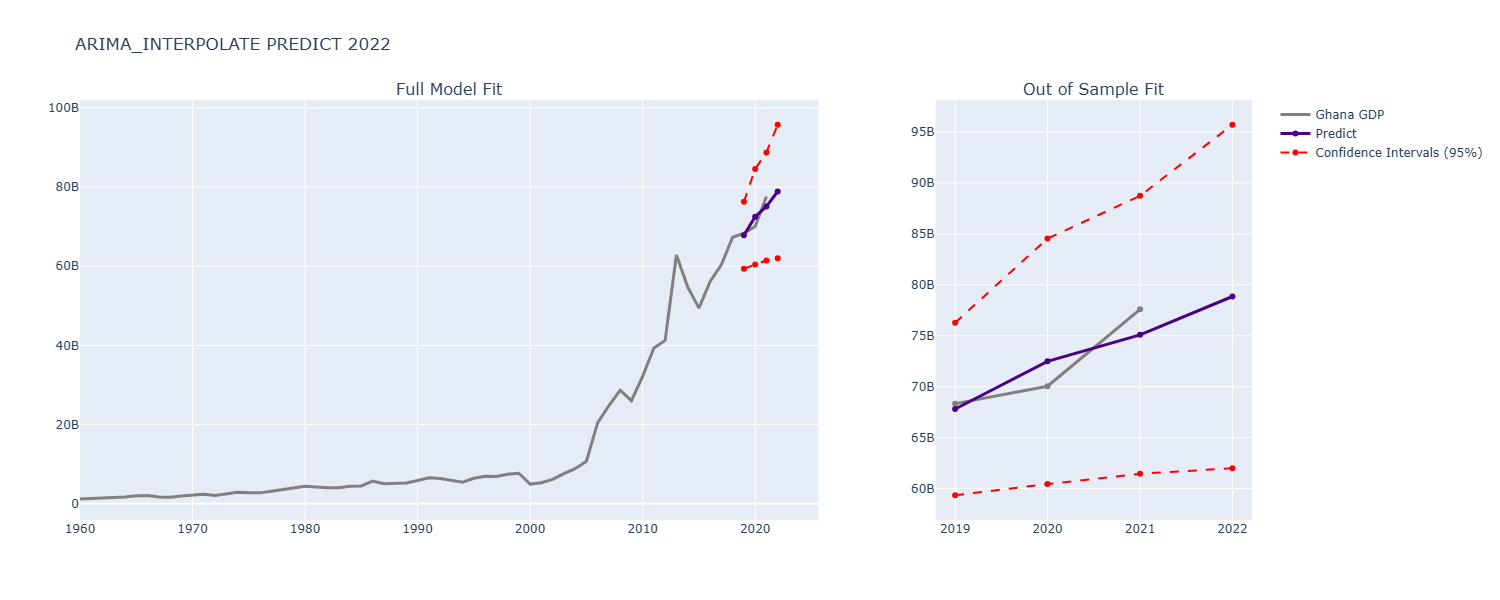

In [127]:
# Преобразуем индексы в строки формата 'YYYY-MM-DD'
full_index_str = ghana_gdp_new.index.strftime('%Y-%m-%d')
test_index_str = test_ghana.index.strftime('%Y-%m-%d')

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Full Model Fit', 'Out of Sample Fit'],
    column_widths=[0.7, 0.3]
)

# Левая панель — полное соответствие модели
fig.add_trace(go.Scatter(
    y=pred_df['GDP (current US$)'],
    x=full_index_str,
    showlegend=True,
    name='Ghana GDP',
    line={'color':'gray', 'width':3}
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds'],
    x=test_index_str,
    showlegend=True,
    name='Predict',
    line={'color':'indigo', 'width':3}
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds_lower'],
    x=test_index_str,
    showlegend=True,
    name='Confidence Intervals (95%)',
    line={'color':'red', 'width':2, 'dash':'dash'}
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds_upper'],
    x=test_index_str,
    showlegend=False,
    line={'color':'red', 'width':2, 'dash':'dash'}
), row=1, col=1)

# Правая панель — прогноз вне выборки
fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['GDP (current US$)'],
    x=test_index_str,
    showlegend=False,
    name='Ghana GDP',
    line={'color':'gray', 'width':3}
), row=1, col=2)

fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds'],
    x=test_index_str,
    showlegend=False,
    line={'color':'indigo', 'width':3}
), row=1, col=2)

fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds_lower'],
    x=test_index_str,
    showlegend=False,
    name='Confidence Intervals_lower (95%)',
    line={'color':'red', 'width':2, 'dash':'dash'}
), row=1, col=2)

fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds_upper'],
    x=test_index_str,
    showlegend=False,
    name='Confidence Intervals_upper (95%)',
    line={'color':'red', 'width':2, 'dash':'dash'}
), row=1, col=2)

fig.update_layout(
    height=600,
    width=1500,
    title_text='ARIMA_INTERPOLATE PREDICT 2022'
)

fig.show()


Модель предсказала ВВП Ганы за 2022 год на уровне 78,9 млрд USD (7.89×10¹⁰) с доверительным интервалом от 62,0 до 95,7 млрд USD. При этом темп роста ВВП существенно замедлится — с почти 11% в 2021 году до 1,7% в 2022.